In [1]:
%cd /home/rguillaume/developpements/Publications/2024_Guillaume-Castel_PatternEffect_on_TCR/reviews

/home/rguillaume/developpements/Publications/2024_Guillaume-Castel_PatternEffect_on_TCR/reviews


In [2]:
import xarray as xr 
import lenapy 
import xesmf as xe
import numpy as np
import warnings
warnings.simplefilter('ignore',)
from xmip.preprocessing import correct_lon
import matplotlib.pyplot as plt
plt.style.use('robin')
plt.rcParams['font.family'] = 'sans'

from scipy.integrate import solve_ivp
import glob
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
import seaborn as sns
import dask.bag as db

from xmip.preprocessing import correct_lon
from xarrayutils import xr_linregress
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
# from lenapy.plotting import plot_timeseries_uncertainty
import cmcrameri.cm as cmc 
import cmocean.cm as cmo
color_pattern = 'C1'
color_nopattern = 'C2'
color_total='0.7'
import os
from scipy.stats import linregress
from scipy.optimize import curve_fit
import warnings

from matplotlib.font_manager import fontManager
fontManager.addfont('../Arial.ttf')
fontManager.addfont('../Arial-bold.ttf')
plt.rcParams['font.sans-serif'] = 'Arial'
# plt.rcParams['mathtext.fontset'] = 'dejavuserif'


pica = 1/6
small_fig = 19*pica
med1_fig = 27*pica
med2_fig = 33*pica
large_fig = 39*pica

line_guide = dict(ls='-', lw=.8, color='0.7')

In [3]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [4]:
# colors = ["#4059AD", "#97D8C4", "#6B9AC4", "#FAB942"]
# # Create a new color cycler object with the given colors
# cycler = plt.cycler(color=colors)
# # Apply the cycler to the default property cycle of matplotlib
# plt.rcParams['axes.prop_cycle'] = cycler


# Load data

In [5]:
ds = xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/review/full_preprocessed.nc').isel(time=range(0,150))
ds = correct_lon(ds).sortby('lon')
ds['pattern_tos_1pct'] = ds['pattern_tos_1pct'].where(ds.tos_control_grid!=1)
ds_lbd = xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/review/lbd_pi_iceSAF_correct.nc')

ds_hist = xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/outputs/historical_pattern/dRp_hist_all_model.nc')
ds_hist = (ds_hist - ds_hist.isel(time=range(10)).mean('time'))
ds_hist_m = ds_hist.mean('member_id')


In [6]:
gf_directory = '/projets/EMC2/data/Models/GFMIP/preliminary_spatial_feedbacks-main/data/'
list_gf_models = os.listdir(gf_directory)


list_gf_regridded = []
for model in tqdm(list_gf_models):
    with xr.open_dataset(f"{gf_directory}/{model}") as ds_raw:
        if "spatial_feedbacks_from_both" in ds_raw.variables:
            data = ds_raw.spatial_feedbacks_from_both
        else:
            data = ds_raw.spatial_feedbacks_from_warming
    # weights = xr.ones_like(data)*np.cos(np.deg2rad(data.latitude))
    # weights = weights/weights.sum(['longitude','latitude'])
    # data = data*weights
    data = data.rename(longitude='lon',latitude='lat')

    regridded_ds = xe.Regridder(data, ds.tos_control_grid, 'conservative_normed', periodic=True)(data).assign_coords(GF_source=model.split('.')[0])
    list_gf_regridded.append(regridded_ds)
greens_functions = xr.concat(list_gf_regridded, dim='GF_source' )
greens_functions = greens_functions.where(greens_functions!=0)
# greens_functions = greens_functions.where(greens_functions.count('GF_source')==greens_functions.count('GF_source').max())
greens_functions.attrs['units'] = 'W/m²'
greens_functions.attrs['long_name'] = "Green's functions coefficients"

# weights = xr.ones_like(greens_functions)*np.cos(np.deg2rad(greens_functions.lat))
# weights = weights/weights.sum(['lon','lat'])
# greens_functions = greens_functions*weights

weights = xr.ones_like(greens_functions)*np.cos(np.deg2rad(greens_functions.lat)).where(greens_functions.notnull())
weights = weights/weights.sum(['lon','lat'])
greens_functions_normed = greens_functions*weights

all_gf = greens_functions.where(greens_functions!=0)
# all_gf = all_gf.where(all_gf.count('GF_source')==all_gf.count('GF_source').max())
mean_gf = all_gf.mean('GF_source')

all_gf_normed = greens_functions_normed.where(greens_functions_normed!=0)
# all_gf = all_gf.where(all_gf.count('GF_source')==all_gf.count('GF_source').max())
mean_gf_normed = all_gf_normed.mean('GF_source')

  0%|          | 0/6 [00:00<?, ?it/s]

# Postprocessing

In [7]:
pattern_mean = ds.pattern_tos_1pct.sel(time=slice(61,80)).mean('time').interpolate_na('lon')
# pattern_mean = pattern_mean.where(pattern_mean>-2,-2).where(pattern_mean<2,2)
pattern_mean_regrid = xe.Regridder(pattern_mean, greens_functions, 'bilinear', periodic=True)(pattern_mean)


dRp_hist = (ds_hist_m.pattern*all_gf).weighted(np.cos(np.deg2rad(ds_hist_m.lat))).mean(['lon','lat'])
# all_gf = xr.concat([xe.Regridder(gf_zhang, gf_dong, 'conservative', periodic=True)(gf_zhang).assign_coords(GF_source='zhang'),
#                     gf_dong.assign_coords(GF_source='dong'),
#                     gf_zhou.assign_coords(GF_source='zhou'),
#                     ], dim='GF_source' )


# Main  tables

## Table 2 : $\lambda_u$

In [8]:
ds_lbd = xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/review/lbd_pi_iceSAF_correct.nc')
df_lbd = ds_lbd.lbd_u_sst.to_series().unstack()[['piSST-pxK','amip-p4K','amip-m4K']]
df_lbd['mean_val'] = df_lbd.mean(axis=1)
df_lbd["sigma"] = df_lbd.iloc[:,:3].std(axis=1)
df_lbd['iceSAF'] = ds_lbd.ice_surf_albedo_feedback_cmip6
df_lbd['lbd_u'] = ds_lbd.lbd_u_icecorr.mean('method')

summary_styler = df_lbd.agg(["mean", "std"]).style \
                   .format(precision=2) \
                   .relabel_index(["Mean", "sigma"])

print(df_lbd.fillna('-').style.format(precision=2).concat(summary_styler).to_latex())
# df_lbd

\begin{tabular}{llrlrlrr}
method & piSST-pxK & amip-p4K & amip-m4K & mean_val & sigma & iceSAF & lbd_u \\
model &  &  &  &  &  &  &  \\
BCC-CSM2-MR & - & -1.79 & -1.85 & -1.82 & 0.04 & 0.35 & -1.47 \\
CESM2 & -1.53 & -1.75 & -1.77 & -1.68 & 0.13 & 0.33 & -1.35 \\
CNRM-CM6-1 & -1.45 & -1.39 & -1.65 & -1.50 & 0.14 & 0.43 & -1.07 \\
CanESM5 & - & -1.21 & -1.18 & -1.20 & 0.03 & 0.38 & -0.81 \\
E3SM-1-0 & - & -1.56 & - & -1.56 & - & 0.28 & -1.28 \\
GFDL-CM4 & - & -1.82 & -1.88 & -1.85 & 0.04 & 0.45 & -1.40 \\
GISS-E2-1-G & - & -1.92 & - & -1.92 & - & 0.22 & -1.70 \\
HadGEM3-GC31-LL & -1.31 & -1.33 & -1.35 & -1.33 & 0.02 & 0.34 & -1.00 \\
IPSL-CM6A-LR & -1.34 & -1.25 & -1.53 & -1.37 & 0.14 & 0.39 & -0.98 \\
MIROC6 & - & -1.99 & - & -1.99 & - & 0.42 & -1.57 \\
MRI-ESM2-0 & - & -1.79 & -1.85 & -1.82 & 0.04 & 0.49 & -1.33 \\
NorESM2-LM & - & -1.80 & - & -1.80 & - & 0.33 & -1.47 \\
Mean & -1.41 & -1.63 & -1.63 & -1.65 & 0.07 & 0.37 & -1.29 \\
sigma & 0.10 & 0.27 & 0.26 & 0.26 & 0.05 & 0.08 & 0.2

## Table 3: Compare forcing to piClim + land corrections

In [9]:
ds_sstClim = xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/outputs/dF_sstClim.nc')

df_F = pd.concat([ds.f.sel(GF_source='mean').to_series(),ds.f.sel(GF_source='mean').to_series()*np.log(4)/np.log(1.01), ds_sstClim.dF.to_series()], axis=1)

df_F.columns = ['f','ERF_mean','sstClim']
df_F['land_corrections'] = -(ds_lbd.lbd_u_sst.mean('method')*ds_sstClim.dT).to_series()
df_F['sstClim_corrected'] = df_F.sstClim + df_F.land_corrections
df_F = df_F[['f','ERF_mean','sstClim_corrected','sstClim', 'land_corrections']]
# df_F['f'] = ds.f.sel(GF_source='mean').to_series()
# df_F.loc[df_F.index!='NorESM2-LM'].corr()
print(df_F.style.format(dict(f="{:.03f}", ERF_mean ="{:.02f}", sstClim ="{:.02f}", sstClim_corrected ="{:.02f}",land_corrections ="{:.02f}"),na_rep='-', ).to_latex())
print(df_F.agg(['mean','std']).style.format(dict(f="{:.03f}", ERF_mean ="{:.02f}", sstClim ="{:.02f}", sstClim_corrected ="{:.02f}",land_corrections ="{:.02f}"),na_rep='-', ).to_latex())

# df_F.agg(['mean','std']).style.format(precision=3)

\begin{tabular}{lrrrrr}
 & f & ERF_mean & sstClim_corrected & sstClim & land_corrections \\
model &  &  &  &  &  \\
BCC-CSM2-MR & 0.061 & 8.56 & - & - & - \\
CESM2 & 0.071 & 9.82 & 9.89 & 8.90 & 0.99 \\
CNRM-CM6-1 & 0.065 & 9.08 & 8.75 & 7.98 & 0.77 \\
CanESM5 & 0.061 & 8.54 & 8.20 & 7.60 & 0.59 \\
E3SM-1-0 & 0.072 & 10.10 & - & - & - \\
GFDL-CM4 & 0.069 & 9.64 & 9.25 & 8.23 & 1.02 \\
GISS-E2-1-G & 0.066 & 9.20 & 9.16 & 7.96 & 1.19 \\
HadGEM3-GC31-LL & 0.063 & 8.78 & 8.79 & 8.08 & 0.71 \\
IPSL-CM6A-LR & 0.062 & 8.62 & 8.80 & 8.01 & 0.79 \\
MIROC6 & 0.058 & 8.11 & 8.26 & 7.33 & 0.92 \\
MRI-ESM2-0 & 0.056 & 7.79 & 8.41 & 7.66 & 0.75 \\
NorESM2-LM & 0.053 & 7.41 & 9.25 & 8.25 & 1.00 \\
\end{tabular}

\begin{tabular}{lrrrrr}
 & f & ERF_mean & sstClim_corrected & sstClim & land_corrections \\
mean & 0.063 & 8.80 & 8.88 & 8.00 & 0.87 \\
std & 0.006 & 0.81 & 0.52 & 0.43 & 0.18 \\
\end{tabular}



## Table 4: ocean model parameters

In [10]:
ds_mean = ds.sel(GF_source='mean')
lstsq_err = np.sqrt(((ds_mean.integrated_tas.sel(depth='surface', integration_type='full') - ds_mean.tas)**2).mean('time'))
df_2layer = ds_mean[['Cs','Cd','gamma']].to_dataframe()[['Cs','Cd','gamma']]
df_2layer['lstsq_err'] = lstsq_err.to_series()
df_2layer

summary_styler = df_2layer.agg(["mean", "std"]).style \
                   .format(precision=2) \
                   .relabel_index(["Mean", "sigma"])

print(df_2layer.style.format(precision=2).concat(summary_styler).to_latex())

\begin{tabular}{lrrrr}
 & Cs & Cd & gamma & lstsq_err \\
model &  &  &  &  \\
BCC-CSM2-MR & 5.82 & 86.69 & 0.67 & 0.09 \\
CESM2 & 8.20 & 67.03 & 1.02 & 0.13 \\
CNRM-CM6-1 & 8.20 & 67.03 & 1.02 & 0.18 \\
CanESM5 & 8.77 & 51.75 & 0.77 & 0.11 \\
E3SM-1-0 & 9.06 & 28.32 & 0.79 & 0.14 \\
GFDL-CM4 & 9.44 & 56.03 & 0.85 & 0.10 \\
GISS-E2-1-G & 10.08 & 121.43 & 0.75 & 0.16 \\
HadGEM3-GC31-LL & 7.89 & 40.05 & 0.95 & 0.11 \\
IPSL-CM6A-LR & 7.83 & 36.68 & 0.95 & 0.16 \\
MIROC6 & 8.11 & 76.03 & 1.11 & 0.15 \\
MRI-ESM2-0 & 7.16 & 135.96 & 0.99 & 0.10 \\
NorESM2-LM & 8.27 & 73.40 & 1.00 & 0.15 \\
Mean & 8.24 & 70.03 & 0.91 & 0.13 \\
sigma & 1.09 & 32.49 & 0.14 & 0.03 \\
\end{tabular}



#  Main Figures

## Figure 1: Plot linear forcing data

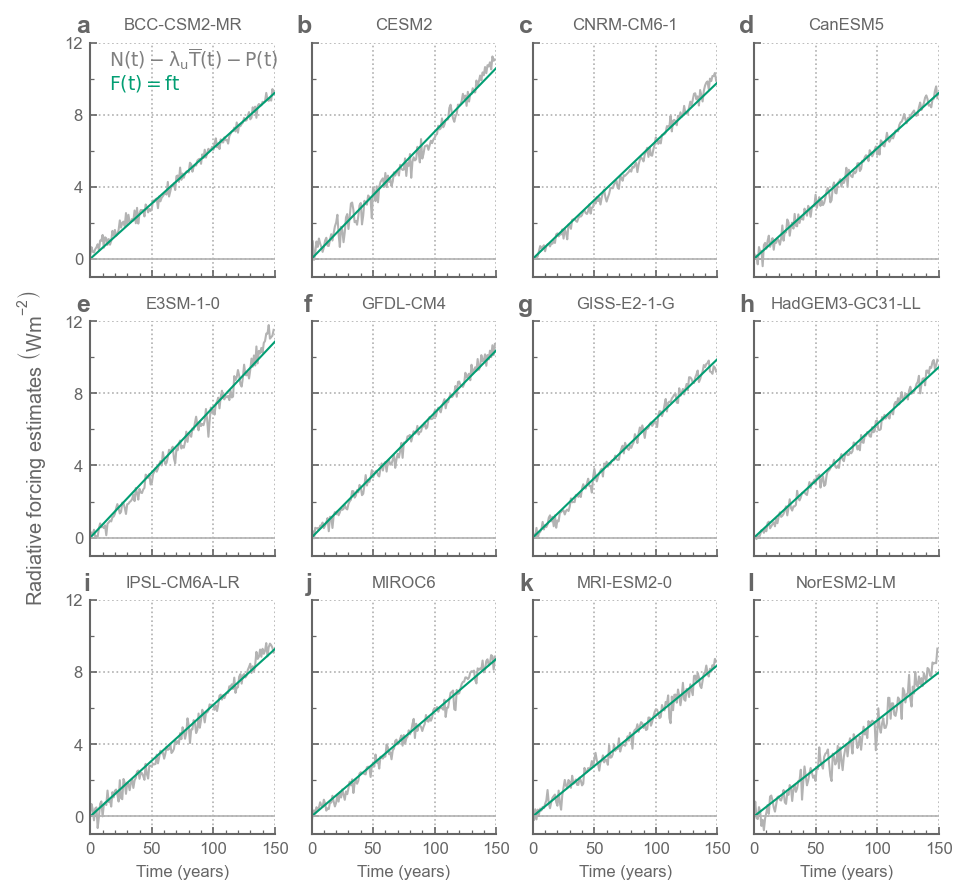

In [12]:
fig, axs = plt.subplots(3,4,figsize=(large_fig,6), sharex=True, sharey=True)
for k, ax in enumerate(axs.flatten()):
    ds_model = ds.isel(model=k)
    ds_model
    y = ds_model.eei - ds_model.dRp_gf - ds_model.dRu  #.xtime.filter('lanczos', cutoff=10, order=1)
    # ds_model.dRp_gf.sel(GF_source='zhou').plot(ax=ax, color='0.8')
    # ds_model.dRp_gf.sel(GF_source='dong').plot(ax=ax, color='0.8')
    # ds_model.dRp_gf.sel(GF_source='zhang').plot(ax=ax, color='0.8')
    # ds_model.eei.plot(ax=ax, color='.5')
    y.sel(GF_source='mean').plot(ax=ax, color='0.7', label='$N - \lambda_u dT - dP$')
    # ax.fill_between(ds_model.time, eei_reco.min('GF_source'), eei_reco.max('GF_source'), color='C1', alpha=.3, lw=0)
    ax.axline((0,0), slope=ds_model.f.sel(GF_source='mean'), color='C2', label='$dF = ft$')
    # fit_F_quad.sel(model=ds_model.model.values, GF_source='mean').plot(color='C1', ax=ax)
    # ds_model.dRp_gf.mean('GF_source').plot(ax=ax, color='C1')
    ax.set_title(ds_model.model.values, size=8)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.xaxis.set_major_locator(mticker.MultipleLocator(50))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(10))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(4))
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(2))
    ax.axhline(0,  **line_guide)
    ax.grid()
    ax.set_ylim(-1,12)
    ax.set_xlim(0,150)
    if k>7:
        ax.set_xlabel('Time (years)')
    ax.text(0,1.042,chr(ord('a')+k), transform=ax.transAxes, weight='bold', size=12, ha='right')
fig.supylabel(r'Radiative forcing estimates $\left(Wm^{-2}\right)$')    
# axs[0,0].legend(loc='upper left')
axs[0,0].text(0.1,0.9,'$N(t)-\lambda_u \overline{T}(t)-P(t)$',transform=axs[0,0].transAxes, size=9, color='0.5', weight='normal', font='DejaVu Sans')
axs[0,0].text(0.1,0.8,'$F(t) = ft$',transform=axs[0,0].transAxes, size=9, color='C2', weight='normal', font='DejaVu Sans')
plt.tight_layout(w_pad=0)
plt.savefig("submission_plots/dF_estimates.pdf")
plt.savefig("submission_plots/dF_estimates.svg")

## Figure 2: comparing P from residual or from diagnostics

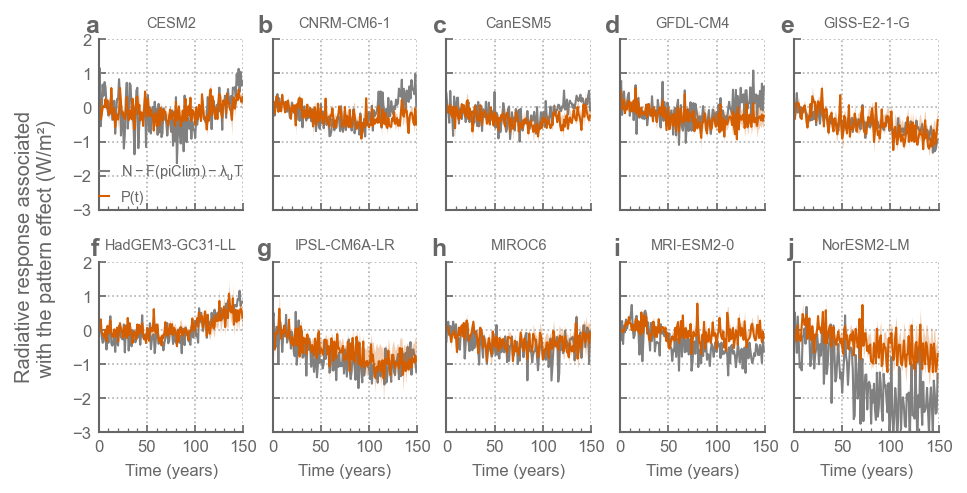

In [13]:
fig, axs = plt.subplots(2,5, figsize=(large_fig,5*2/3), sharex=True, sharey=True)
# eei_reco = 
all_delta = []
models = df_F.dropna().index
for k, ax in enumerate(axs.flatten()):
    eei = ds.sel(model=models[k]).eei
    f = df_F.loc[models[k]].sstClim_corrected
    dRp_reco = eei - np.log(1.01)/np.log(4)*f*ds.time - ds.sel(model=models[k]).dRu
    dRp_reco.plot(ax=ax, label=r'$N - F(piClim) - \lambda_u T$', color='.5', lw=1,)
    dRp_gf = ds.dRp_gf.sel(model=models[k])
    dRp_gf.sel(GF_source='mean').plot(ax=ax, color='C3', label='P(t)')
    quantiles_dRp = dRp_gf.quantile([0.17,0.83],'GF_source')
    # ax.fill_between(ds_model.time, dRp.min('GF_source'), dRp.max('GF_source'), color='C2', alpha=.3, lw=0)
    # 17 - 83
    ax.fill_between(quantiles_dRp.time, quantiles_dRp.sel(quantile=0.17), quantiles_dRp.sel(quantile=.83), color='C3', alpha=.3, lw=0, zorder=100)
    all_delta.append(dRp_reco -ds.dRp_gf.sel(model=models[k]) )
    ax.set_title(models[k], size=7)
    ax.set_xlabel('')
    ax.legend().remove()
    ax.grid()
    ax.set_ylabel('')
    ax.set_ylim(-3,2)
    ax.set_xlim(0,150)
    ax.xaxis.set_minor_locator(plt.MultipleLocator(10))
    ax.xaxis.set_major_locator(plt.MultipleLocator(50))
    ax.text(0,1.042,chr(ord('a')+k), transform=ax.transAxes, weight='bold', size=12, ha='right')
    if k>4:
        ax.set_xlabel('Time (years)')
fig.supylabel('Radiative response associated\n with the pattern effect (W/m²)')
axs[0,0].legend(bbox_to_anchor=(.5,.35), fontsize=7, handlelength=.7, loc='upper center', )
plt.tight_layout(w_pad=0)
plt.savefig('submission_plots/supplementary/comparing_pattern_effect_from_residuals_or_from_greens_functions.png', dpi=300)
plt.savefig('submission_plots/comparing_pattern_effect_from_residuals_or_from_greens_functions.pdf', dpi=300)

## Figure 3: Rp/Ru timeseries

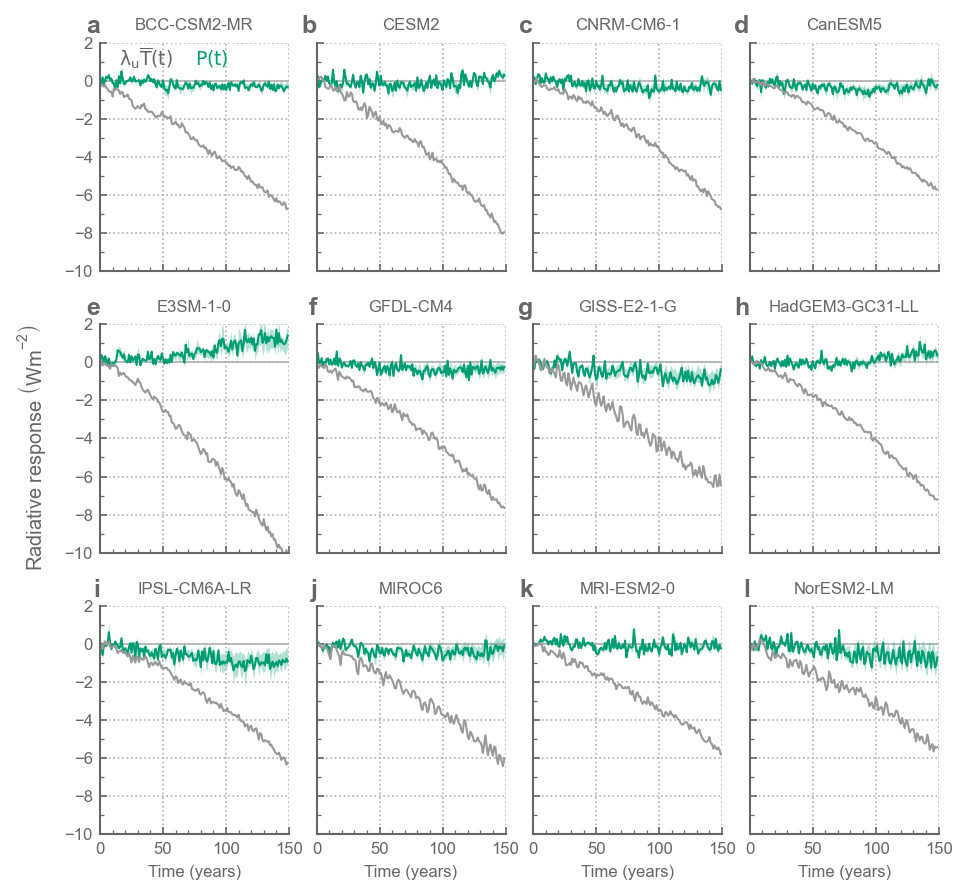

In [ ]:
fig, axs = plt.subplots(3,4,figsize=(large_fig,6), sharex=True, sharey=True)
for k, ax in enumerate(axs.flatten()):
    ds_model = ds.isel(model=k)
    dRp = ds_model.dRp_gf
    dRu = ds_model.dRu

    dRp.sel(GF_source='mean').plot(ax=ax, color='C2')
    # dRp.isel(GF_source=slice(None, -1)).median('GF_source').plot(ax=ax, color='C2')
    dRu.plot(ax=ax, color='.6')
    quantiles_dRp = dRp.isel(GF_source=slice(None, -1)).quantile([0.17,0.83],'GF_source')
    # ax.fill_between(ds_model.time, dRp.min('GF_source'), dRp.max('GF_source'), color='C2', alpha=.3, lw=0)
    # 17 - 83
    ax.fill_between(quantiles_dRp.time, quantiles_dRp.sel(quantile=0.17), quantiles_dRp.sel(quantile=.83), color='C2', alpha=.3, lw=0)
    # ds_model.dRp_gf.mean('GF_source').plot(ax=ax, color='.6')
    ax.set_title(ds_model.model.values, size=8)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.xaxis.set_major_locator(mticker.MultipleLocator(50))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(10))
    ax.axhline(0, **line_guide, zorder=0)
    ax.grid()
    ax.set_ylim(-10,2)
    ax.set_xlim(0,150)
    if k>7:
        ax.set_xlabel('Time (years)')
    ax.text(0,1.042,chr(ord('a')+k), transform=ax.transAxes, weight='bold', size=12, ha='right')
    ax.yaxis.set_major_locator(mticker.MultipleLocator(2))
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(1))
fig.supylabel(r'Radiative response $\left(Wm^{-2}\right)$')    
axs[0,0].text(0.1,0.9,'$\lambda_u \overline{T}(t)$',transform=axs[0,0].transAxes, size=9, color='.4', weight='normal', font='DejaVu Sans')
axs[0,0].text(0.5,0.905,'$P(t)$',transform=axs[0,0].transAxes, size=9, color='C2', weight='normal', font='DejaVu Sans')
plt.tight_layout(w_pad=0)
plt.savefig("submission_plots/Rp_and_Ru.pdf")
plt.savefig("submission_plots/Rp_and_Ru.svg")

## Figure 4: Multimodel mean and intermodel std maps

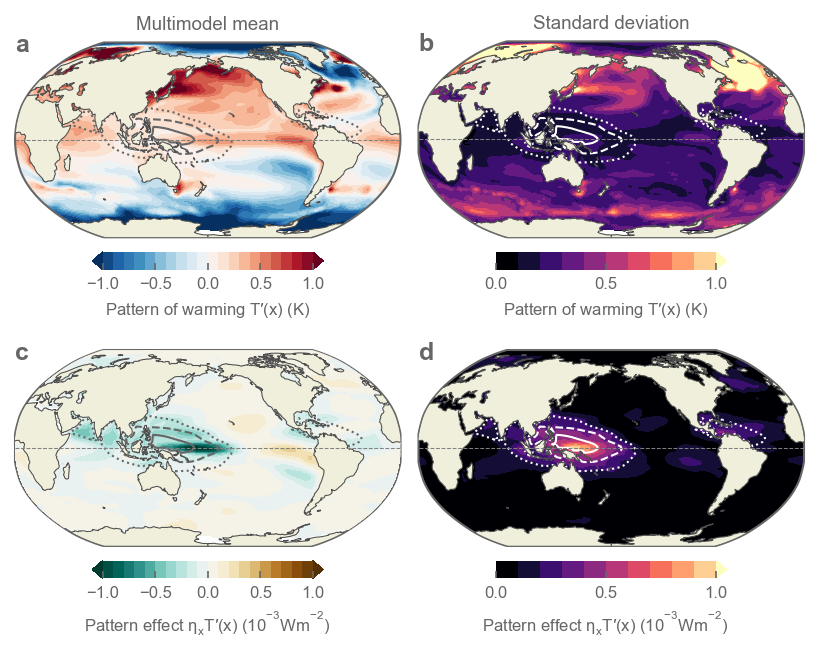

In [ ]:
fig, axs = plt.subplot_mosaic("""
                              AB
                              CD
                              """,
                              per_subplot_kw=dict(ABCD=dict(projection=ccrs.Robinson(180))),
                              height_ratios = [10,10], figsize=(med2_fig,4.5))

plot1 = pattern_mean.mean('model').plot.contourf(cmap='RdBu_r', 
                                ax=axs['A'],
                                transform=ccrs.PlateCarree(),
                                cbar_kwargs=dict(orientation='horizontal', pad=0.05, shrink=.6, ticks=np.arange(-1,1.1,.5), aspect=13, label='Pattern of warming $T{\prime}(x)$ (K)'),
                                levels=np.arange(-1,1.1,.1))



plot2 = pattern_mean.std('model').plot.contourf(levels=np.arange(0,1.1,.1),
                               cmap='magma', 
                               ax=axs['B'],
                               transform=ccrs.PlateCarree(),
                               extend='max',
                               cbar_kwargs=dict(orientation='horizontal', pad=0.05, shrink=.6, ticks=np.arange(0,1.1,.5), aspect=13,label='Pattern of warming $T{\prime}(x)$ (K)'))



plot3 = (mean_gf_normed*pattern_mean_regrid*1e3).interpolate_na('lon').mean('model').plot.contourf(ax=axs['C'], transform=ccrs.PlateCarree(), 
                                                                           cmap='BrBG_r',
                                                                           levels=np.arange(-1,1.1,.1),
                                                                           zorder=50,
                                                                           extend='both',
                                                                           cbar_kwargs=dict(orientation='horizontal', aspect=13, pad=0.05, shrink=.6, ticks=np.arange(-1,1.1,.5), label='Pattern effect $\eta_x T{\prime}(x)$ ($10^{-3}Wm^{-2}$)'))

plot4 = (mean_gf_normed*pattern_mean_regrid*1e3).interpolate_na('lon').fillna(0).std('model').plot.contourf(ax=axs['D'], transform=ccrs.PlateCarree(), 
                                                                          cmap='magma',
                                                                          levels=np.arange(0,1.1,.1),
                                                                          extend='max',
                                                                          cbar_kwargs=dict(orientation='horizontal', aspect=13, pad=0.05, shrink=.6, ticks=np.arange(0,1.1,.5), label='Pattern effect $\eta_x T{\prime}(x)$ ($10^{-3}Wm^{-2}$)'))

for plot in [plot1, plot2, plot3, plot4]:
    cbar = plot.colorbar
    cbar.outline.set_visible(False)
    cbar.minorlocator = mticker.MultipleLocator(10000)
for k,ax in enumerate(axs.values()):
    color_gf = '.4' if k%2==0 else '1'
    (1e3*mean_gf_normed).interpolate_na('lon').plot.contour(ax=ax,levels=np.arange(-3,4.1,1), colors=color_gf, linestyles=['-','--',':'], linewidths=[1,1,1,0], zorder=100, transform=ccrs.PlateCarree())
    ax.add_feature(cfeat.LAND, zorder=100, edgecolor='.3', linewidth=.5)
    ax.axhline(0, ls='--',zorder=101, color='.5', lw=.5)
    ax.text(0,0.95,chr(ord('a')+k), weight='bold', transform=ax.transAxes, size=12)

    
axs['A'].set_title('Multimodel mean', size=9)
# axs['A'].text(-.1,.5,'Multimodel mean', ha='left', va='center',transform=axs['A'].transAxes, rotation=90)
axs['B'].set_title('Standard deviation', size=9)
# axs['C'].text(-.1,.5,'Standard deviation', ha='left', va='center',transform=axs['C'].transAxes, rotation=90)
axs['C'].set_title('')
axs['D'].set_title('')
plt.tight_layout()
plt.savefig('submission_plots/multimodel_mean_pattern.pdf')
plt.savefig('submission_plots/multimodel_mean_pattern.svg')

## Figure 5: GMST change induced by the pattern effect in 1pctCO2

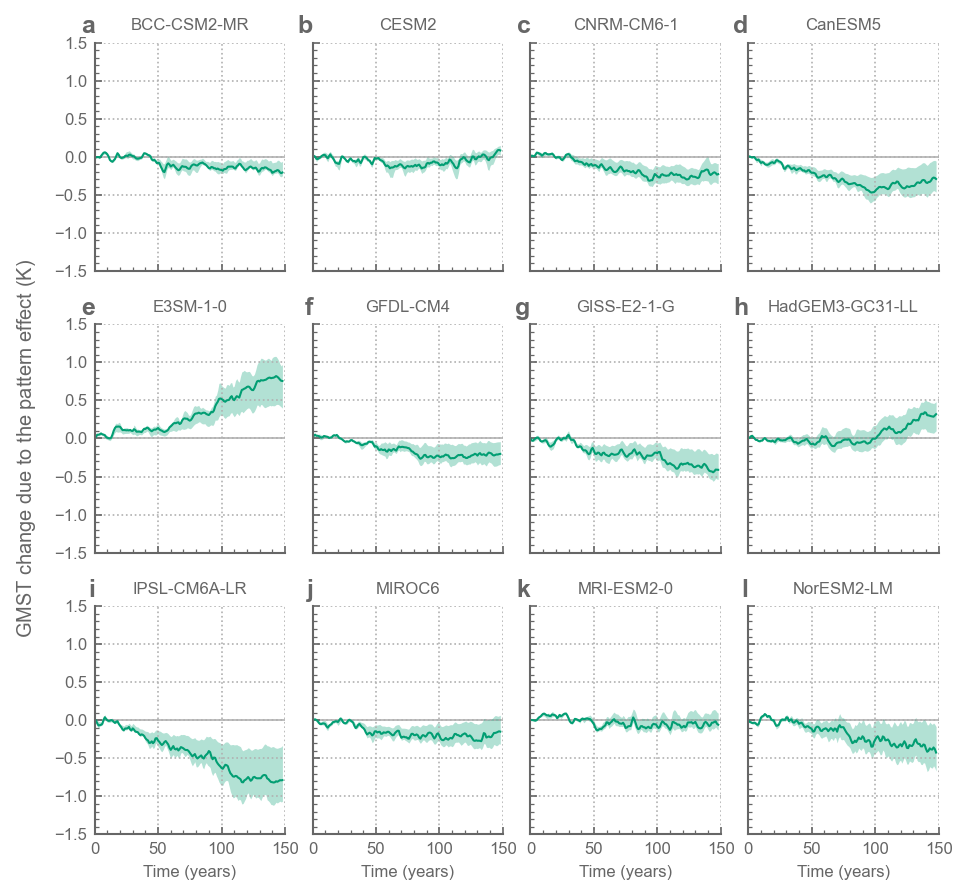

In [ ]:
fig, axs = plt.subplots(3,4,figsize=(large_fig,6), sharex=True, sharey='row')
for k, ax in enumerate(axs.flatten()):
    ds_model = ds.isel(model=k)
    dTp = ds_model.integrated_tas.sel(integration_type='only_pattern', depth='surface')#.xtime.filter('lanczos', cutoff=10, order=1)

    dTp.sel(GF_source='mean').plot(ax=ax, color='C2')
    quantiles_dTp = dTp.isel(GF_source=slice(None, -1)).quantile([0.17,0.83],'GF_source')
    # ax.fill_between(ds_model.time, dTp.min('GF_source'), dTp.max('GF_source'), color='C2', alpha=.3, lw=0)
    ax.fill_between(quantiles_dTp.time, quantiles_dTp.sel(quantile=0.17), quantiles_dTp.sel(quantile=.83), color='C2', alpha=.3, lw=0)

    # ds_model.dRp_gf.mean('GF_source').plot(ax=ax, color='C1')
    ax.set_title(ds_model.model.values, size=8)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.xaxis.set_major_locator(mticker.MultipleLocator(50))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(10))
    ax.axhline(0, **line_guide, zorder=0)
    ax.grid()
    ax.set_ylim(-1.5,1.5)
    ax.set_xlim(0,150)
    ax.yaxis.set_major_locator(mticker.MultipleLocator(.5))
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(.1))
    if k>7:
        ax.set_xlabel('Time (years)')
    ax.text(0,1.042,chr(ord('a')+k), transform=ax.transAxes, weight='bold', size=12, ha='right')

fig.supylabel('GMST change due to the pattern effect ($K$)')    
plt.tight_layout(w_pad=0)
plt.savefig('submission_plots/Tp.pdf')
plt.savefig('submission_plots/Tp.svg')

## Figure 6: TCR plot

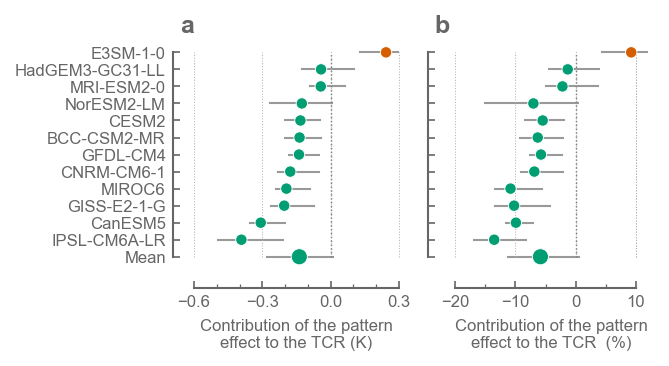

In [13]:
fig, axs = plt.subplots(1,2,figsize=(med1_fig, 2.5), sharey=True)

df_TCR = ds.integrated_tas.sel(time=slice(61,80), depth='surface').isel(GF_source=slice(None, -1)).mean('time').to_series().unstack().sort_values('no_pattern')#.reset_index()
df_TCR['only_pattern_percent'] = ((df_TCR.only_pattern)/(df_TCR.no_pattern)*100)
df_TCR_mean = df_TCR.copy().reset_index()
df_TCR_mean['model'] = 'Mean'
df_TCR_mean = df_TCR_mean.set_index(['GF_source','model'])
df_TCR_wmean = pd.concat([df_TCR, df_TCR_mean], axis=0)
df_TCR_wmean = df_TCR_wmean.sort_values('only_pattern', ascending=False)
# only_pattern = ((df_TCR_wmean.only_pattern)).sort_values()
# only_percent_percent = ((df_TCR_wmean.only_pattern)/(df_TCR_wmean.full)*100).sort_values()
# ((mean_vals.only_pattern)/(mean_vals.full)*100).sort_values().plot.barh(ax=axs[1])
order = df_TCR_wmean.groupby('model').mean().only_pattern.sort_values(ascending=False).index
order = [model for model in order if model !='Mean'] + ['Mean']
sns.pointplot(df_TCR_wmean, 
              x='only_pattern', y='model', order=order, 
              ax=axs[0], errorbar=('pi',66),
              linestyle='none',
              markersize=0, linewidth=1,
              clip_on=False,
              color='.6')
sns.pointplot(df_TCR_wmean, 
              x='only_pattern_percent', y='model', order=order, 
              ax=axs[1], errorbar=('pi',66),
              linestyle='none',
              markersize=0, linewidth=1,
              clip_on=False,
              color='.6')

# sns.barplot(df_TCR_wmean, 
#               x='only_pattern', y='model', order=df_TCR_wmean.groupby('model').mean().only_pattern.sort_values(ascending=False).index, 
#               ax=axs[0],
#               errorbar=None,
#               linestyle='none',
#               width=.15, color='.6'
#               )

# sns.barplot(df_TCR_wmean, 
#               x='only_pattern_percent', y='model', order=df_TCR_wmean.groupby('model').mean().only_pattern.sort_values(ascending=False).index, 
#               ax=axs[1],
#               errorbar=None,
#               linestyle='none',
#               width=.15, color='.6'
#               )

df_mean = df_TCR_wmean.groupby('model').mean().loc[order]
df_mean['colors'] = ["C2" if data>0 else 'C3' for data in df_mean.only_pattern ]
df_mean['size'] = [5 if model=='Mean' else 3 for model in df_mean.index ]

sns.scatterplot(df_mean, x='only_pattern', y='model', hue='colors', size='size', palette = ['C3','C2'], ax=axs[0], zorder=100, sizes=[30,60])
sns.scatterplot(df_mean, x='only_pattern_percent', y='model', hue='colors', size='size', palette = ['C3','C2'], ax=axs[1], zorder=100, sizes=[30,60])

axs[0].legend().remove()
axs[1].legend().remove()
# sns.scatterplot(df_TCR.groupby('model').mean().loc[order[:-1]].reset_index()).plot(y='model', x='only_pattern', ax=axs[0])

    # ax.set_ylim(12,0)
axs[0].set_xlim(-.6, .3)
axs[1].set_xlim(-21, 13)
axs[0].xaxis.set_major_locator(plt.MultipleLocator(.3))
axs[0].xaxis.set_minor_locator(plt.MultipleLocator(.1))
axs[1].xaxis.set_major_locator(plt.MultipleLocator(10))
axs[1].xaxis.set_minor_locator(plt.MultipleLocator(5))
sns.despine(offset = 10)

for k,ax in enumerate(axs):
    # ax.grid(axis='x')
    # ax.tick_params(left=False)
    # ax.axvline(0,ymin=12, ymax=0, **line_guide)
    ax.spines['left'].set_bounds(12,0)
    xticks=ax.get_xticks()
    for x in xticks:
        ax.vlines(x=x, ymin=12, ymax=0, color='.7', linestyle=':', linewidth=0.5)
    ax.vlines(x=0, ymin=12, ymax=0, color='.5', linestyle=':', linewidth=.7)
    ax.text(0,1.042,chr(ord('a')+k), transform=ax.transAxes, weight='bold', size=12, ha='right')
axs[0].vlines(x=.3, ymin=12, ymax=0, color='.7', linestyle=':', linewidth=0.5, clip_on=False)
axs[1].vlines(x=10, ymin=12, ymax=0, color='.7', linestyle=':', linewidth=0.5, clip_on=False)
axs[1].spines['bottom'].set_bounds(-20,10)
axs[0].set_xlabel('Contribution of the pattern\neffect to the TCR (K)')
axs[1].set_xlabel('Contribution of the pattern\neffect to the TCR  (%)')
axs[0].set_ylabel('')

plt.tight_layout()

plt.savefig('submission_plots/TCR_contribution_from_pattern.pdf')
plt.savefig('submission_plots/TCR_contribution_from_pattern.svg')

## TCR table

In [14]:
quant_only_pattern = df_TCR_wmean.groupby('model').quantile([0.17, 0.83]).only_pattern.unstack()
uncertainty_only_pattern = '[' + quant_only_pattern[0.17].round(2).astype(str) + '; ' + quant_only_pattern[0.83].round(2).astype(str) + ']'

quant_only_pattern_percent = df_TCR_wmean.groupby('model').quantile([0.17, 0.83]).only_pattern_percent.unstack()
uncertainty_only_pattern_percent = '[' + quant_only_pattern_percent[0.17].round(1).astype(str) + '; ' + quant_only_pattern_percent[0.83].round(1).astype(str) + ']'

quant_full = df_TCR_wmean.groupby('model').quantile([0.17, 0.83]).full.unstack()
uncertainty_full = '[' + quant_full[0.17].round(2).astype(str) + '; ' + quant_full[0.83].round(2).astype(str) + ']'

quant_no_pattern = df_TCR_wmean.groupby('model').quantile([0.17, 0.83]).no_pattern.unstack()
uncertainty_no_pattern = '[' + quant_no_pattern[0.17].round(2).astype(str) + '; ' + quant_no_pattern[0.83].round(2).astype(str) + ']'


only_pattern_data = df_mean.only_pattern.round(2).astype(str) + '  '+uncertainty_only_pattern
full_data = df_mean.full.round(2).astype(str) + '  '+uncertainty_full
no_pattern_data = df_mean.no_pattern.round(1).astype(str) + '  '+uncertainty_no_pattern
only_pattern_percent_data = (df_mean.only_pattern/df_mean.no_pattern*100).round(1).astype(str) + '  '+uncertainty_only_pattern_percent

df_table = pd.DataFrame(dict(full=full_data, no_pattern=no_pattern_data, only_pattern=only_pattern_data, only_pattern_percent=only_pattern_percent_data))

df_table = df_table.loc[[model for model in df_table.index if model != 'Mean'] + ['Mean']]
print(df_table.to_latex())

\begin{tabular}{lllll}
\toprule
 & full & no_pattern & only_pattern & only_pattern_percent \\
model &  &  &  &  \\
\midrule
BCC-CSM2-MR & 1.95  [1.94; 1.96] & 2.1  [2.0; 2.14] & -0.14  [-0.2; -0.04] & -6.5  [-9.3; -2.2] \\
CESM2 & 2.2  [2.17; 2.23] & 2.3  [2.28; 2.38] & -0.13  [-0.2; -0.04] & -5.7  [-8.4; -1.9] \\
CNRM-CM6-1 & 2.3  [2.28; 2.34] & 2.5  [2.4; 2.53] & -0.18  [-0.23; -0.05] & -7.1  [-9.1; -2.0] \\
CanESM5 & 2.64  [2.63; 2.66] & 3.0  [2.84; 2.99] & -0.31  [-0.35; -0.2] & -10.4  [-11.6; -7.1] \\
E3SM-1-0 & 3.06  [3.01; 3.1] & 2.8  [2.72; 2.97] & 0.24  [0.13; 0.31] & 8.6  [4.4; 11.9] \\
GFDL-CM4 & 2.18  [2.17; 2.19] & 2.3  [2.23; 2.37] & -0.14  [-0.18; -0.05] & -6.0  [-7.6; -2.2] \\
GISS-E2-1-G & 1.67  [1.66; 1.68] & 1.9  [1.75; 1.92] & -0.2  [-0.26; -0.07] & -10.9  [-13.3; -4.2] \\
HadGEM3-GC31-LL & 2.69  [2.68; 2.71] & 2.7  [2.63; 2.82] & -0.04  [-0.12; 0.1] & -1.5  [-4.4; 3.9] \\
IPSL-CM6A-LR & 2.32  [2.29; 2.36] & 2.7  [2.53; 2.84] & -0.39  [-0.49; -0.21] & -14.4  [-17.0;

# Figure 7: Bode diagram

In [19]:
df_bode = df_2layer.copy()
df_bode['lbd_u'] = ds.lbd_u.to_series()
ds_bode = df_bode.to_xarray()
b = (-ds_bode.lbd_u + ds_bode.gamma)/ds_bode.Cs + ds_bode.gamma/ds_bode.Cd
b_s = (-ds_bode.lbd_u + ds_bode.gamma)/ds_bode.Cs - ds_bode.gamma/ds_bode.Cd
delta = b**2 + 4*(ds_bode.lbd_u*ds_bode.gamma)/(ds_bode.Cs*ds_bode.Cd)
tau_f = -(ds_bode.Cs*ds_bode.Cd)/(2*ds_bode.lbd_u*ds_bode.gamma)*(b-np.sqrt(delta))
tau_s = -(ds_bode.Cs*ds_bode.Cd)/(2*ds_bode.lbd_u*ds_bode.gamma)*(b+np.sqrt(delta))
phi_f = ds_bode.Cs/(2*ds_bode.gamma)*(b_s-np.sqrt(delta))
phi_s = ds_bode.Cs/(2*ds_bode.gamma)*(b_s+np.sqrt(delta))
Lambda = 1/(ds_bode.Cs*(phi_s-phi_f))
a_s = (phi_f*tau_s)/(ds_bode.Cs*(phi_s-phi_f))*ds_bode.lbd_u
a_f = -(phi_s*tau_f)/(ds_bode.Cs*(phi_s-phi_f))*ds_bode.lbd_u

omega1 = 1/np.sqrt(tau_f*tau_s)
omega2 = 1/(a_f*tau_s + a_s*tau_f)
omega0 =-ds_bode.lbd_u/ds_bode.Cs
ksi = (tau_s + tau_f)/(2*np.sqrt(tau_f*tau_s))

omega = xr.DataArray(10**(np.arange(-5,5,0.01)), dims=['omega'], coords=dict(omega=10**(np.arange(-5,5,0.01))))

H1 = 1/(np.sqrt(1+omega/omega0)**2)
H2 = (np.sqrt(1+(omega/omega2)**2))/(np.sqrt((1-(omega/omega1)**2)**2 + (2*ksi*omega/omega1)**2))

omegabar = omega/omega1
phi1 = -np.arctan(omega/omega0)
phi2a =np.arctan(omega/omega2)
phi2b = np.arctan((2*ksi*omegabar)/(omegabar**2-1)) 
phi2b = phi2b.where(phi2b<0, phi2b-np.pi)
phi2 =  phi2a+phi2b


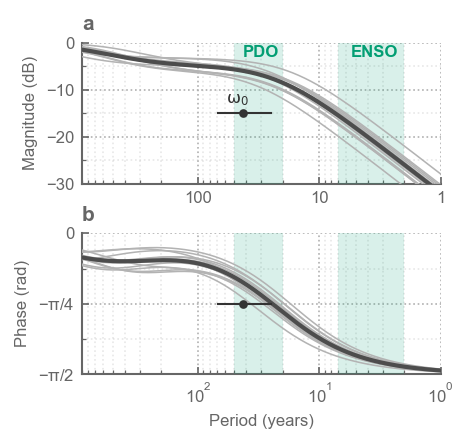

In [20]:
fig, axs = plt.subplots(2,1, figsize=(small_fig, 3))
for model in H2.model:
    axs[0].plot(2*np.pi/omega,20*np.log10(H2.sel(model=model)), zorder=200,  label='2 couches', color='.7', lw=.75)
    axs[1].plot(2*np.pi/omega, phi2.sel(model=model), zorder=200, color='0.7', lw=.75, label='2 couches', yunits='radians')
axs[0].plot(2*np.pi/omega,20*np.log10(H2.mean('model')), zorder=200,  label='2 couches', color='.3', lw=2)
axs[1].plot(2*np.pi/omega, phi2.mean('model'), zorder=200, color='0.3', lw=2, label='2 couches', yunits='radians')
    

for ax in axs:
    ax.set_xscale('log')
    ax.set_xlim(900, .99)
    ax.axvspan(2,7, zorder=100, alpha=.15, color='C2', lw=0)
    ax.axvspan(20,50, zorder=100, alpha=.15, color='C2', lw=0)
    
    # for model in omega0.model:
    #     ax.axvline((2*np.pi/omega0.sel(model=model)), color='C1')
    ax.grid(which='minor', alpha=.3)
    ax.grid()
    # sns.despine(top=False, right=False, ax=ax)
axs[0].plot([(2*np.pi/omega0).min().values,
             (2*np.pi/omega0).max().values],
            [-15,-15],
             zorder=100, alpha=1, color='.2', lw=1)
axs[0].scatter((2*np.pi/omega0).mean().values,
            -15,
             zorder=100, alpha=1, color='.2', lw=1, s=10)
axs[1].plot([(2*np.pi/omega0).min().values,
             (2*np.pi/omega0).max().values],
            [-np.pi/4,-np.pi/4],
             zorder=1000, alpha=1, color='.2', lw=1)
axs[1].scatter((2*np.pi/omega0).mean().values,
            -np.pi/4,
             zorder=10000, alpha=1, color='.2', lw=1, s=10,)



axs[0].set_ylim(-30,0)
axs[0].text(30,-3,'PDO', ha='center', weight='bold',zorder=1000, color='C2')
axs[0].text(47,-13,'$\omega_0$', ha='center', weight='normal',zorder=1000, font='DejaVu sans', color='.2')
axs[0].text(3.5,-3,'ENSO', ha='center', weight='bold',zorder=1000, color='C2')


axs[0].spines['left'].set_bounds((-30, 0))
# axs[0].legend(title="Modèle d'océan :")
axs[1].set_xlabel('Period (years)')
axs[0].set_ylabel('Magnitude (dB)')
axs[0].xaxis.set_major_formatter("{x:.0f}")
import matplotlib.ticker as mticker
axs[0].yaxis.set_major_locator(mticker.MultipleLocator(10))
axs[0].yaxis.set_minor_locator(mticker.MultipleLocator(5))

# axs[1].yaxis.set_major_locator(mticker.MultipleLocator(np.pi/4))
axs[1].yaxis.set_minor_locator(mticker.MultipleLocator(np.pi/8))
axs[1].set_yticks([-np.pi/4*k for k in range(3)])
axs[1].set_yticklabels(["0","$-\pi$/4", "$-\pi$/2"])
axs[1].set_ylim(-np.pi/2,0)
axs[1].set_ylabel('Phase (rad)')

axs[0].set_title('a', loc='left', weight='bold')
axs[1].set_title('b', loc='left', weight='bold')
plt.tight_layout(h_pad=0)
plt.savefig('submission_plots/bode.pdf')
plt.savefig('submission_plots/bode.svg')

## Figure 8: Compare historical Pattern with 1pctCO2

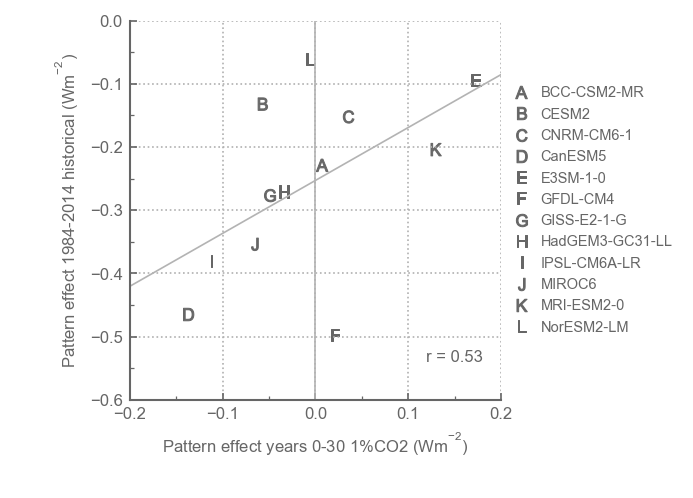

In [198]:
fig, ax = plt.subplots(figsize=(med1_fig,3.2))
trends_hist = dRp_hist.assign_coords(time=range(1850,2015)).sel(time=slice(1900,1960)).polyfit('time', deg=1).polyfit_coefficients.sel(degree=1,drop=True).mean('GF_source')*10
trends_1pct = ds.dRp_gf.sel(time=slice(0,60)).polyfit('time', deg=1).polyfit_coefficients.sel(degree=1,drop=True).sel(GF_source='mean')*10

pattern_1pct_0to30 = ds.dRp_gf.sel(time=range(0,30)).mean('time').sel(GF_source='mean')
pattern_hist_last30 = ds_hist_m.dRp.sel(time=slice("1984","2014")).mean('time').mean('GF_source')

df=pd.DataFrame(dict(hist=pattern_hist_last30.to_series(), pct1=pattern_1pct_0to30.to_series())).dropna().reset_index()

markers = [f"${chr(ord('A')+k)}$" for k in range(12)]
sns.scatterplot(df, x='pct1', y='hist',  style='model', markers=markers, edgecolor=None, clip_on=False, color='.4')
df.columns = ["model","thist","t1pct"]

ax.legend(loc='center left', fontsize=7,bbox_to_anchor=(1,.5) )

ax.set_xlim(-.2,.2)
ax.set_ylim(-0.6,0)
ax.xaxis.set_major_locator(mticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.05))
ax.yaxis.set_major_locator(mticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.05))

ax.axvline(0, **line_guide)
ax.grid()
ax.set_xlabel('Pattern effect years 0-30 1%CO2 ($Wm^{-2}$)')
ax.set_ylabel('Pattern effect 1984-2014 historical ($Wm^{-2}$)')
lr = linregress(df.t1pct, df.thist)
ax.axline((0,lr.intercept), slope=lr.slope, **line_guide)
ax.text(0.95,0.1, f"r = {+lr.rvalue:.02f}", transform=ax.transAxes, ha='right', color='.4')
plt.tight_layout()
plt.savefig('submission_plots/compare_1pct_pattern_with_hist_pattern.pdf')
plt.savefig('submission_plots/compare_1pct_pattern_with_hist_pattern.svg')

# Supplementary figures

## Figure S1 Green's functions plot

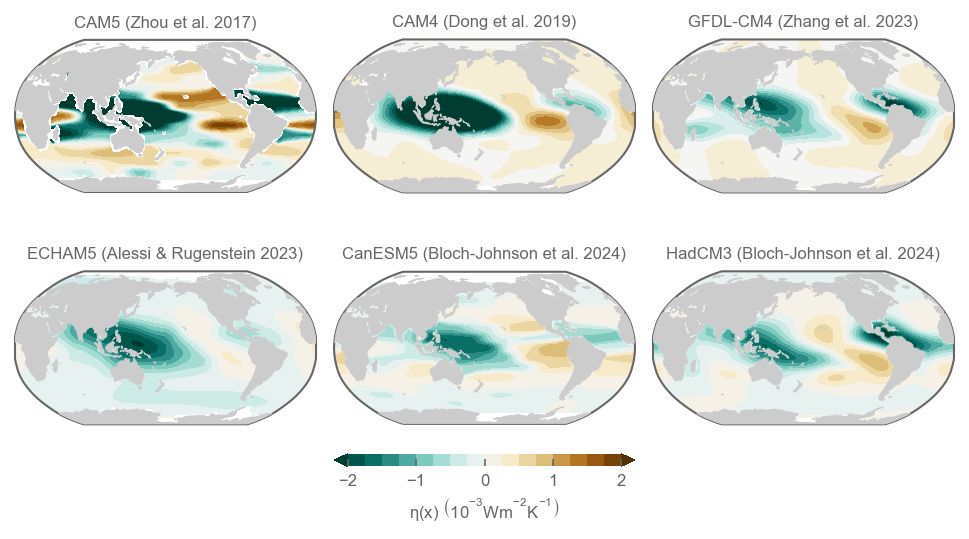

In [25]:
fig, axs = plt.subplot_mosaic("""
                              ABC
                              EFG
                              .D.
                              """,
                              figsize=(large_fig,3.8), height_ratios=[20,20, 1],
                              per_subplot_kw = dict(
                                  ABCEFG = dict(projection=ccrs.Robinson(180)),
                              ))
(all_gf_normed.sel(GF_source='cam4')*1e3).plot.contourf(ax=axs['B'], transform=ccrs.PlateCarree(), add_colorbar=False, cmap='BrBG_r', levels=np.arange(-2,2.1,.25))
(all_gf_normed.sel(GF_source='gfdlam4')*1e3).plot.contourf(ax=axs['C'], transform=ccrs.PlateCarree(), add_colorbar=False, cmap='BrBG_r', levels=np.arange(-2,2.1,.25))
(all_gf_normed.sel(GF_source='echam6')*1e3).plot.contourf(ax=axs['E'], transform=ccrs.PlateCarree(),add_colorbar=False, levels=np.arange(-2,2.1,.25), extend='both', cmap='BrBG_r')
(all_gf_normed.sel(GF_source='canesm5')*1e3).plot.contourf(ax=axs['F'], transform=ccrs.PlateCarree(),add_colorbar=False, levels=np.arange(-2,2.1,.25), extend='both', cmap='BrBG_r')
(all_gf_normed.sel(GF_source='hadcm3')*1e3).plot.contourf(ax=axs['G'], transform=ccrs.PlateCarree(),add_colorbar=False, levels=np.arange(-2,2.1,.25), extend='both', cmap='BrBG_r')
plot = (all_gf_normed.sel(GF_source='cam5')*1e3).plot.contourf(ax=axs['A'], transform=ccrs.PlateCarree(),add_colorbar=False, levels=np.arange(-2,2.1,.25), extend='both', cmap='BrBG_r')

cbar = fig.colorbar(plot, cax=axs['D'],orientation='horizontal')
cbar.outline.set_visible(False)
cbar.minorlocator = mticker.MultipleLocator(10000)

axs['A'].add_feature(cfeat.LAND, edgecolor='k', lw=.5, color='.8', zorder=100)    
axs['B'].add_feature(cfeat.LAND, edgecolor='k', lw=.5, color='.8', zorder=100)    
axs['C'].add_feature(cfeat.LAND, edgecolor='k', lw=.5, color='.8', zorder=100)    
axs['E'].add_feature(cfeat.LAND, edgecolor='k', lw=.5, color='.8', zorder=100)    
axs['F'].add_feature(cfeat.LAND, edgecolor='k', lw=.5, color='.8', zorder=100)    
axs['G'].add_feature(cfeat.LAND, edgecolor='k', lw=.5, color='.8', zorder=100)    

axs['A'].set_title('CAM5 (Zhou et al. 2017)', size=8)
axs['B'].set_title('CAM4 (Dong et al. 2019)', size=8)
axs['C'].set_title('GFDL-CM4 (Zhang et al. 2023)', size=8)

axs['E'].set_title('ECHAM5 (Alessi & Rugenstein 2023)', size=8)
axs['F'].set_title('CanESM5 (Bloch-Johnson et al. 2024)', size=8)
axs['G'].set_title('HadCM3 (Bloch-Johnson et al. 2024)', size=8)

axs['D'].set_xlabel(r'$\eta(x)$ $\left(10^{-3}Wm^{-2}K^{-1}\right)$')
axs['D'].set_xticks(np.arange(-2,2.1,1))

plt.tight_layout()
plt.savefig('submission_plots/supplementary/GF_coefs_horizontal.pdf')
plt.savefig('submission_plots/supplementary/GF_coefs_horizontal.svg')

## Figure S2: compare forcing with piClim

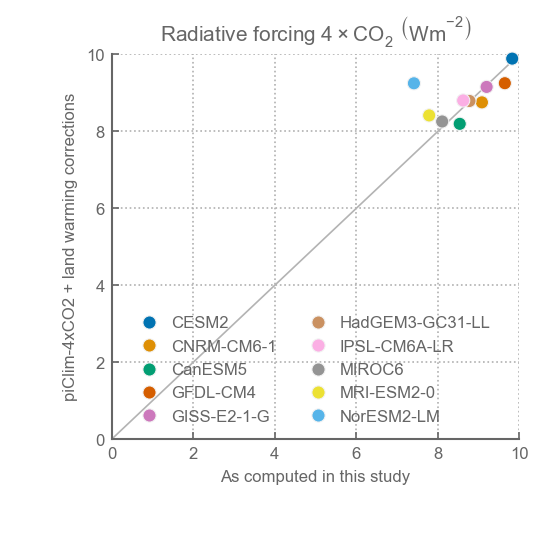

In [161]:
fig, ax = plt.subplots(figsize=(3.5,3.5))
y = ds.eei - ds.dRp_gf - ds.dRu  #.xtime.filter('lanczos', cutoff=10, order=1)
sns.scatterplot(df_F.dropna(), x='ERF_mean', y='sstClim_corrected', ax=ax, 
                hue='model', s=40, edgecolor='0.95', zorder=100, clip_on=False)
plt.axline((8,8), slope=1, ls='-', lw=.8, color='0.7')
ax.grid()
ax.set_ylim(0,10)
ax.set_xlim(0,10)
ax.legend(ncols=2, loc='lower center')
ax.set_title(r'Radiative forcing $4\times CO_2$ $\left(Wm^{-2}\right)$')
ax.set_ylabel(r'piClim-4xCO2 + land warming corrections')
ax.set_xlabel(r'As computed in this study')
plt.tight_layout()
plt.savefig('submission_plots/supplementary/compare_dF_sstClim_land_correction.pdf')
plt.savefig('submission_plots/supplementary/compare_dF_sstClim_land_correction.svg')
 

## Figure S3: EEI closure error versus temperature

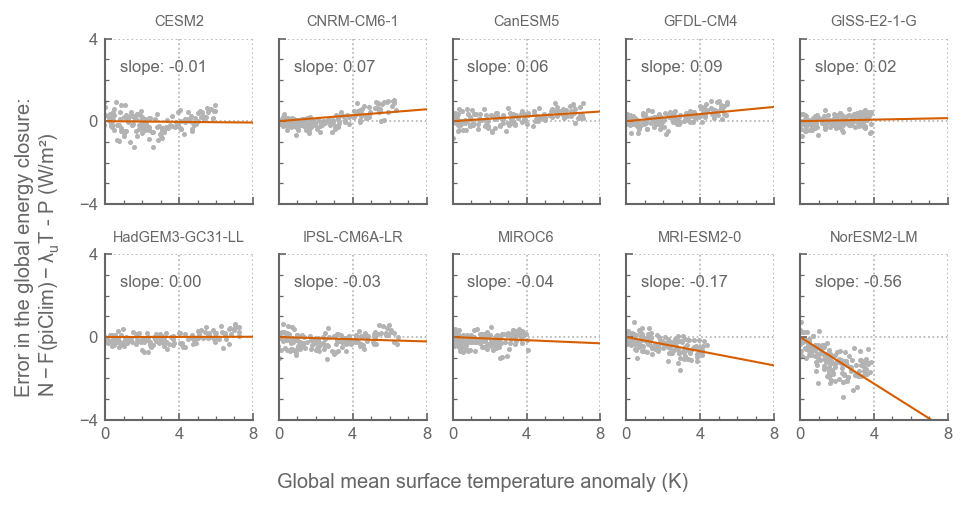

In [169]:
fig, axs = plt.subplots(2,5, figsize=(large_fig,5*2/3), sharex=True, sharey=True)
all_delta = []
models = df_F.dropna().index
for k, ax in enumerate(axs.flatten()):
    eei = ds.sel(model=models[k]).eei
    tas = ds.sel(model=models[k]).tas
    f = df_F.loc[models[k]].sstClim_corrected
    dRp_reco = eei - np.log(1.01)/np.log(4)*f*ds.time - ds.sel(model=models[k]).dRu
    dRp_gf = ds.dRp_gf.sel(model=models[k])#.lntime.plot(ax=ax, label = 'P(t)', add_legend=False, color='C3')
    x = tas 
    y = (-dRp_gf+dRp_reco).mean('GF_source')
    fit = curve_fit(lambda x,a : a*x, x, y)[0][0]
    ax.scatter(x,y, s=2, color='.7')
    ax.axline((0,0), slope=fit, color='C3', ls='-', lw=1)
    ax.text(0.1,0.8, f"slope: {fit:.02f}", transform=ax.transAxes)
    ax.set_title(models[k], size=7)
    ax.set_xlabel('')
    ax.grid()
    ax.set_ylabel('')
    ax.set_ylim(-4,4)
    ax.set_xlim(0,8)
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.xaxis.set_major_locator(plt.MultipleLocator(4))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(4))

fig.supylabel('Error in the global energy closure:\n'+r'$N - F(piClim) - \lambda_u T$ - P (W/m²)')
fig.supxlabel('Global mean surface temperature anomaly (K)')
# axs[0,0].legend(bbox_to_anchor=(-0.05,-0.05), loc ='lower left')
plt.tight_layout(w_pad=1)
plt.savefig('submission_plots/supplementary/residuals_from_global_energy_budget_plotted_against_tas_for_mean_greens_function.svg', dpi=300)

## Figure S4: reconstructing TAS with 2 layer model

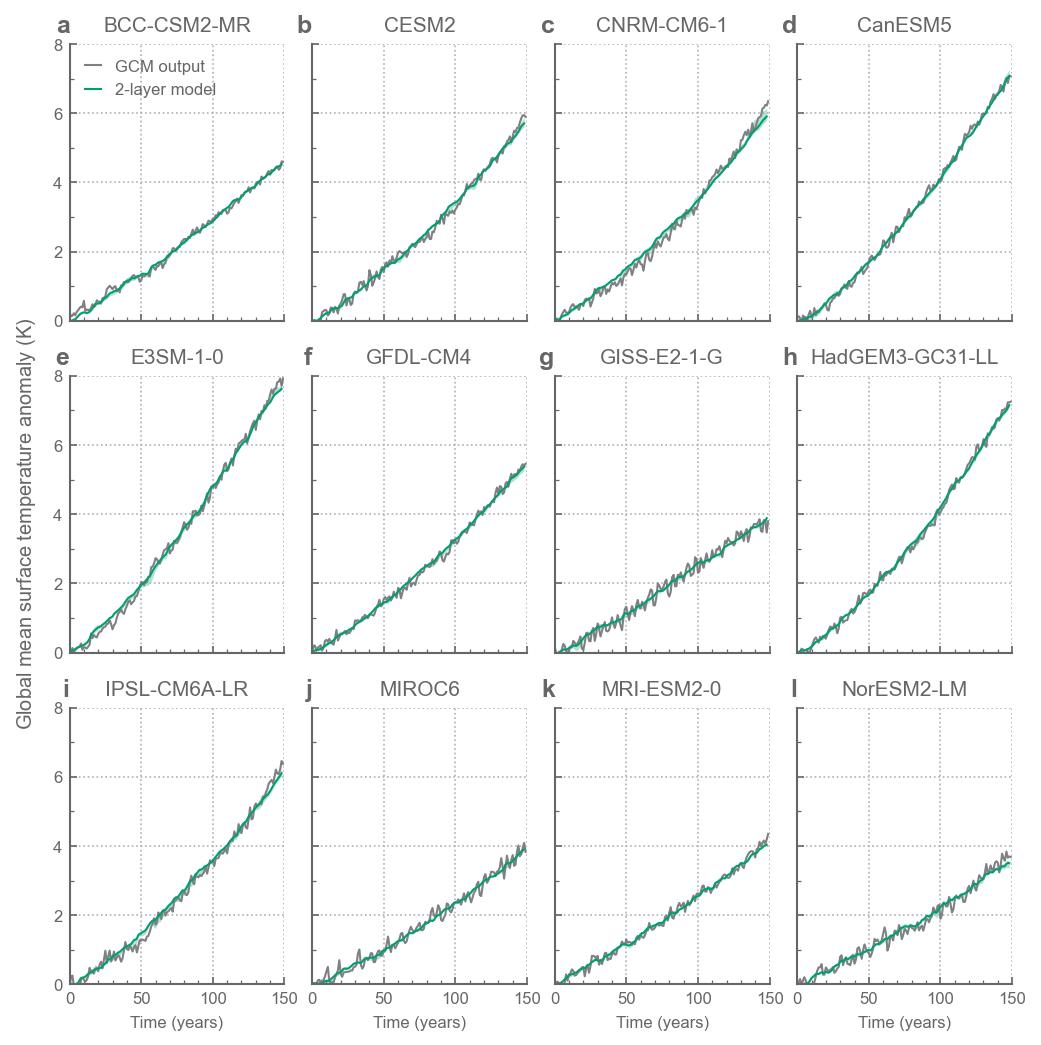

In [ ]:
fig, axs = plt.subplots(3,4,figsize=(7,7), sharex=True, sharey=True)
for k, ax in enumerate(axs.flatten()):
    ds_model = ds.isel(model=k)
    ds_model
    tas_integrated = ds_model.integrated_tas.sel(integration_type='full', depth='surface')
    ds_model.tas.plot(ax=ax, color='.5', label='GCM output')
    tas_integrated.sel(GF_source='mean').plot(ax=ax, color='C2', label='2-layer model')
    ax.fill_between(ds_model.time, tas_integrated.min('GF_source'), tas_integrated.max('GF_source'), color='C2', alpha=.3, lw=0)
    
    ax.set_title(ds_model.model.values, size=10)
    ax.set_ylabel('')
    ax.grid()
    ax.set_xlabel('')
    ax.xaxis.set_major_locator(mticker.MultipleLocator(50))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(10))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(2))
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(1))
    ax.axhline(0, ls=':', lw=1, color='.5')
    ax.set_ylim(0,8)
    ax.set_xlim(0,150)
    if k>7:
        ax.set_xlabel('Time (years)')
    ax.text(0,1.042,chr(ord('a')+k), transform=ax.transAxes, weight='bold', size=12, ha='right')
fig.supylabel('Global mean surface temperature anomaly ($K$)')    
axs[0,0].legend(loc='upper left')
plt.tight_layout(w_pad=0)
plt.savefig("submission_plots/supplementary/Ts_reco.pdf")
plt.savefig("submission_plots/supplementary/Ts_reco.svg")

## Figure S6: dRp timeseries for each GF

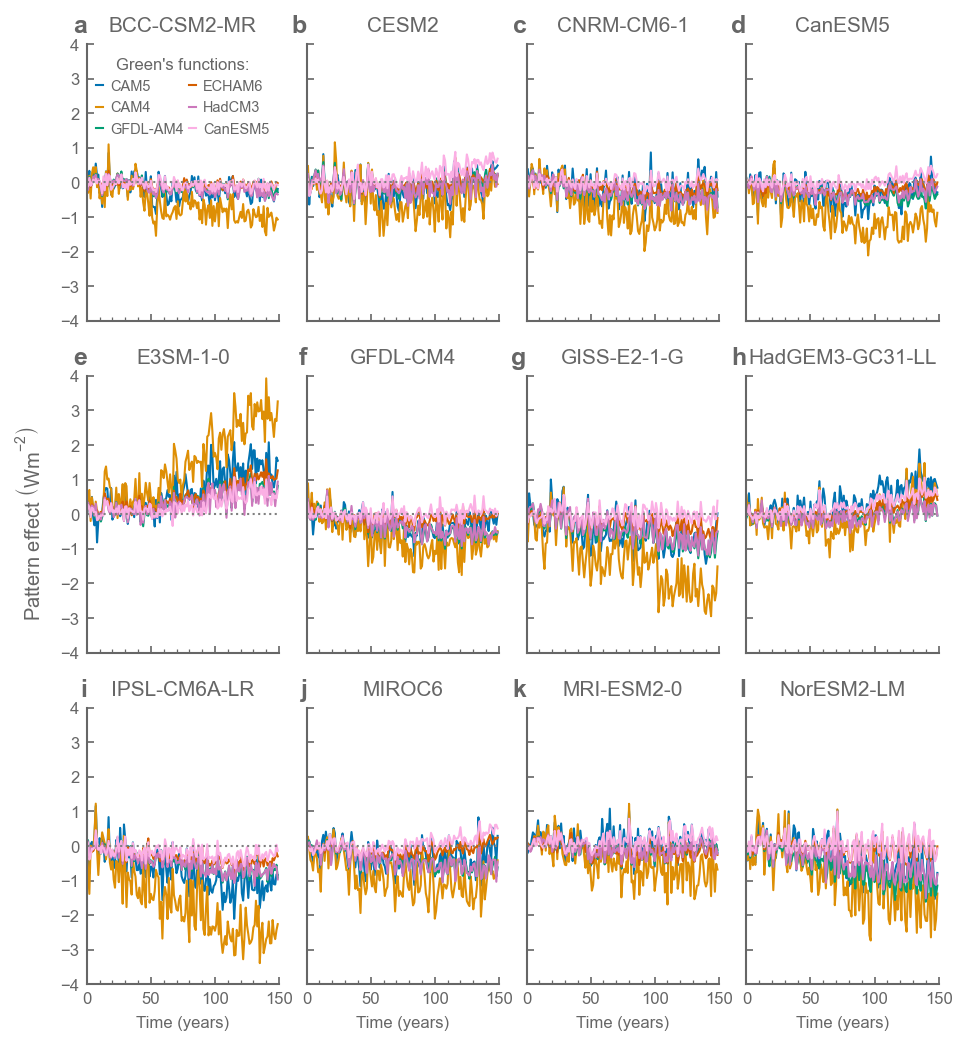

In [26]:
fig, axs = plt.subplots(3,4,figsize=(large_fig,7), sharex=True, sharey=True)
for k, ax in enumerate(axs.flatten()):
    ds_model = ds.isel(model=k)
    dRp = ds_model.dRp_gf#.xtime.filter('lanczos', cutoff=10, order=1)
    # ds_model.dRp_gf.sel(GF_source='zhou').plot(ax=ax, color='0.8')
    # ds_model.dRp_gf.sel(GF_source='dong').plot(ax=ax, color='0.8')
    # ds_model.dRp_gf.sel(GF_source='zhang').plot(ax=ax, color='0.8')
    dRp.sel(GF_source='cam5').plot(ax=ax, lw=1, label='CAM5')
    dRp.sel(GF_source='cam4').plot(ax=ax, lw=1, label='CAM4')
    dRp.sel(GF_source='gfdlam4').plot(ax=ax, lw=1, label='GFDL-AM4')
    dRp.sel(GF_source='echam6').plot(ax=ax, lw=1, label='ECHAM6')
    dRp.sel(GF_source='hadcm3').plot(ax=ax, lw=1, label='HadCM3')
    dRp.sel(GF_source='canesm5').plot(ax=ax, color='C6', lw=1, label='CanESM5')
    # dRp.sel(GF_source='mean').plot(ax=ax, color='.5', lw=1, label='Mean timeseries')
    # ax.fill_between(ds_model.time, dRp.min('GF_source'), dRp.max('GF_source'), color='C1', alpha=.3, lw=0)
    # ds_model.dRp_gf.mean('GF_source').plot(ax=ax, color='C1')
    ax.set_title(ds_model.model.values, size=10)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.xaxis.set_major_locator(mticker.MultipleLocator(50))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(10))
    ax.axhline(0, ls=':', lw=1, color='.5')
    ax.set_ylim(-4,4)
    ax.set_xlim(0,150)
    if k>7:
        ax.set_xlabel('Time (years)')
    ax.text(0,1.042,chr(ord('a')+k), transform=ax.transAxes, weight='bold', size=12, ha='right')
axs[0,0].legend(title="Green's functions:",fontsize=7, ncols=2, handlelength=.5,handletextpad=.5, columnspacing=.3, loc='upper center')
fig.supylabel(r'Pattern effect $\left(Wm^{-2}\right)$')    
plt.tight_layout(w_pad=0)
plt.savefig("submission_plots/supplementary/Rp_all_gf.pdf")
plt.savefig("submission_plots/supplementary/Rp_all_gf.svg")

## Figure S7: CanESM5 multirealisations

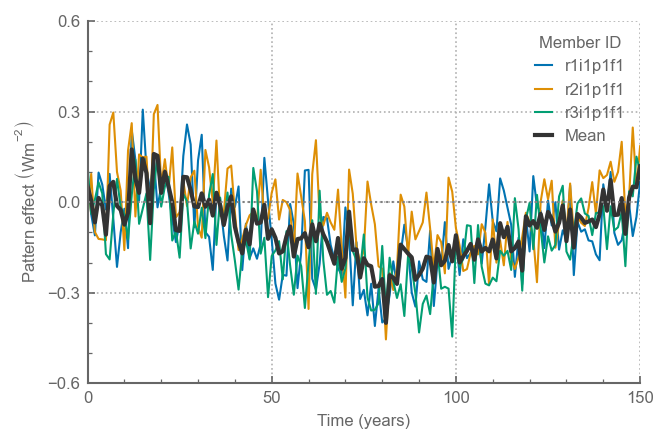

In [27]:
fig, ax = plt.subplots(figsize=(med1_fig,3))
dRp_gf_cam = xr.open_dataarray("/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/review/dRp_1pct_CanESM5_multi_member.nc")
dRp_gf_cam.mean('GF_source').sel(member_id='r1i1p1f1').plot(label='r1i1p1f1', color='C0')
dRp_gf_cam.mean('GF_source').sel(member_id='r2i1p1f1').plot(label='r2i1p1f1', color='C1')
dRp_gf_cam.mean('GF_source').sel(member_id='r3i1p1f1').plot(label='r3i1p1f1', color='C2')
dRp_gf_cam.mean(['GF_source','member_id']).plot(color='.2', lw=2, label='Mean')

ax.legend(title='Member ID')
ax.set_ylim(-.6,.6)
ax.set_xlim(0,150)
ax.xaxis.set_major_locator(mticker.MultipleLocator(50))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(10))
ax.grid()

ax.yaxis.set_major_locator(mticker.MultipleLocator(.3))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(.1))

ax.set_ylabel(r'Pattern effect $\left(Wm^{-2}\right)$')
ax.axhline(0, ls=':', lw=1, color='.5')
ax.set_xlabel('Time (years)')
plt.tight_layout()
plt.savefig('submission_plots/supplementary/CanESM5_multi_member.pdf')
plt.savefig('submission_plots/supplementary/CanESM5_multi_member.svg')

## Figure S8: patterns of warming for all models

0it [00:00, ?it/s]

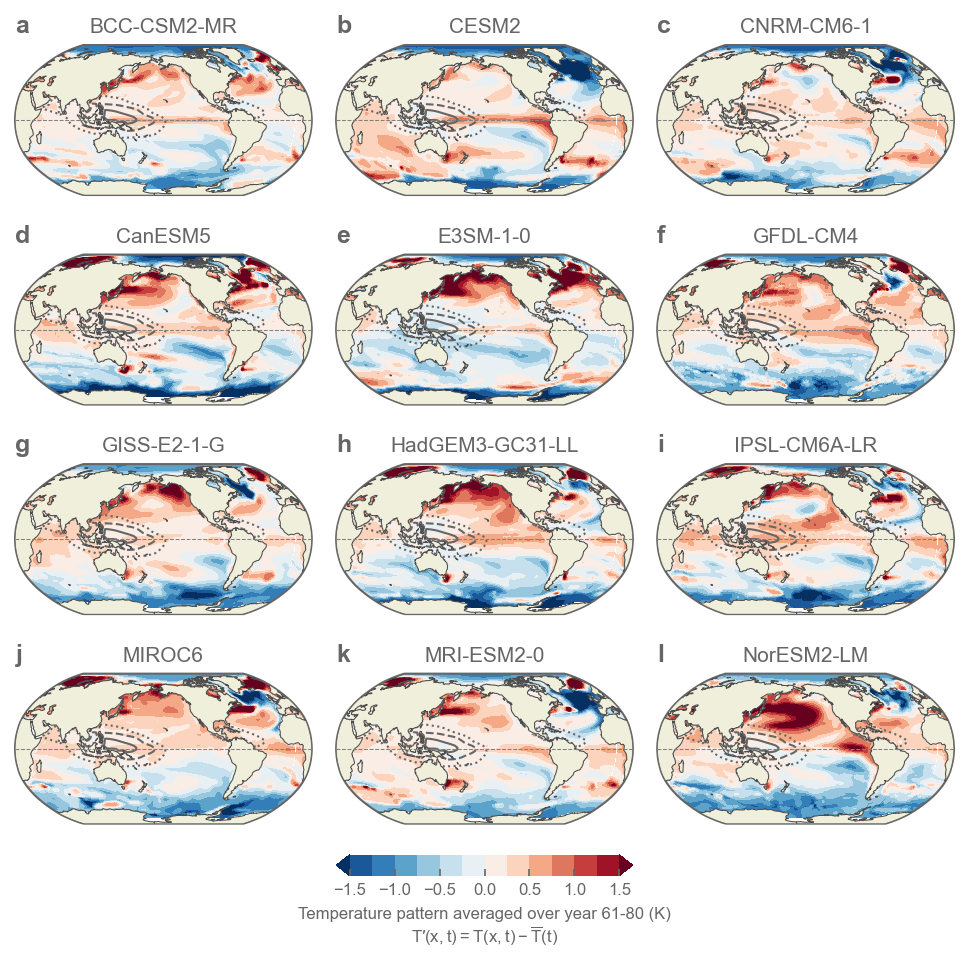

In [32]:
fig, axs = plt.subplot_mosaic("""
                              ABC
                              DEF
                              GHI
                              JKL
                              .c.
                              """,
                              per_subplot_kw=dict(ABCDEFGHIJKL=dict(projection=ccrs.Robinson(200))),
                              height_ratios = [10,10,10,10,1], figsize=(large_fig,6.5))

for k,model in tqdm(enumerate(ds.model.values[:])):
    ax = list(axs.values())[k]
    plot = pattern_mean.sel(model=model).plot.contourf(cmap='RdBu_r', 
                                ax=ax,
                                transform=ccrs.PlateCarree(),
                                levels=np.arange(-1.5,1.7,.25), 
                                add_colorbar=False,)
    color_gf='.4'
    (1e3*mean_gf_normed).interpolate_na('lon').plot.contour(ax=ax,levels=np.arange(-3,4.1,1), colors=color_gf, linestyles=['-','--',':'], linewidths=[1,1,1,0], zorder=100, transform=ccrs.PlateCarree())
    ax.set_title(model)
    ax.set_title(chr(ord('a')+k), loc='left', weight='bold', size=12)
    ax.add_feature(cfeat.LAND, zorder=100, edgecolor='.3', linewidth=.5)
    ax.axhline(0, ls='--',zorder=101, color='.5', lw=.5)
cbar = fig.colorbar(plot, cax=axs['c'], orientation='horizontal',extend='both')
cbar.outline.set_visible(False)
cbar.minorlocator = mticker.MultipleLocator(10000)

axs['c'].set_xlabel('Temperature pattern averaged over year 61-80 (K)\n$T\prime(x,t) = T(x,t)-\overline{T}(t)$')
axs['c'].set_xticks(np.arange(-1.5,1.6,.5))
plt.tight_layout()
# plt.savefig('plots/pattern61-80.pdf')
# plt.savefig('plots/pattern61-80.svg')
plt.savefig('submission_plots/supplementary/pattern61-80.png', dpi=300)
plt.savefig('submission_plots/supplementary/pattern61-80.svg', dpi=300)

## Figure S5: pattern effect maps for all models

0it [00:00, ?it/s]

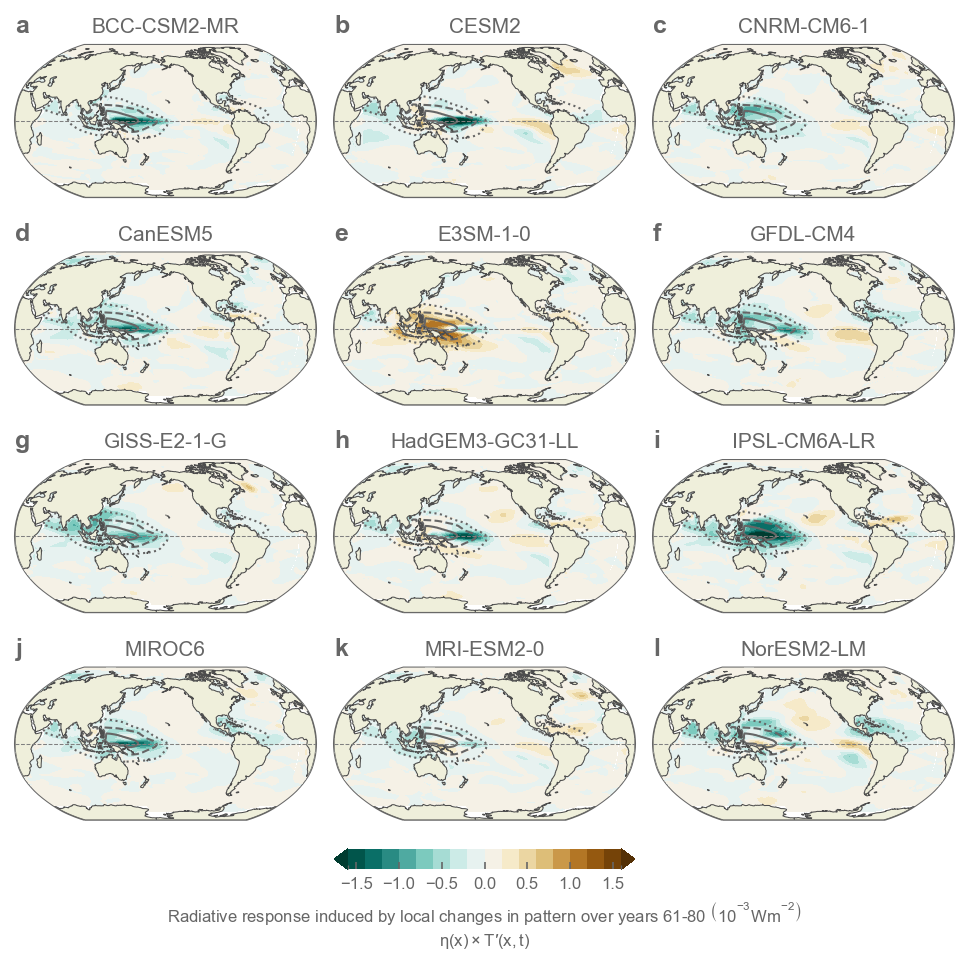

In [29]:
fig, axs = plt.subplot_mosaic("""
                              ABC
                              DEF
                              GHI
                              JKL
                              .c.
                              """,
                              per_subplot_kw=dict(ABCDEFGHIJKL=dict(projection=ccrs.Robinson(200))),
                              height_ratios = [10,10,10,10,1], figsize=(large_fig,6.5))

for k,model in tqdm(enumerate(ds.model.values[:])):
    ax = list(axs.values())[k]
    plot = (mean_gf_normed*pattern_mean_regrid*1e3).interpolate_na('lon').sel(model=model).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), 
                                       cmap='BrBG_r',
                                       levels=np.arange(-1.6,1.7,.2),
                                       zorder=50,
                                       extend='both',
                                       add_colorbar=False)
    
    color_gf='.4'
    (1e3*mean_gf_normed).interpolate_na('lon').plot.contour(ax=ax,levels=np.arange(-3,4.1,1), colors=color_gf, linestyles=['-','--',':'], linewidths=[1,1,1,0], zorder=100, transform=ccrs.PlateCarree())
    ax.set_title(chr(ord('a')+k), loc='left', weight='bold', size=12)
    ax.add_feature(cfeat.LAND, zorder=100, edgecolor='.3', linewidth=.5)
    ax.axhline(0, ls='--',zorder=101, color='.5', lw=.5)
    ax.set_title(model)
cbar = fig.colorbar(plot, cax=axs['c'], orientation='horizontal',extend='both')
cbar.outline.set_visible(False)
cbar.minorlocator = mticker.MultipleLocator(10000)
axs['c'].set_xlabel(r'Radiative response induced by local changes in pattern over years 61-80 $\left(10^{-3}Wm^{-2}\right)$'+'\n'+r'$\eta(x)\times T\prime(x,t)$')
axs['c'].set_xticks(np.arange(-1.5,1.6,.5))
axs['c'].set_xticks(np.arange(-1.5,1.6,.5))

plt.tight_layout()
plt.savefig('submission_plots/supplementary/greens_functions_pattern61-80.png', dpi=300)
plt.savefig('submission_plots/supplementary/greens_functions_pattern61-80.svg', dpi=300)

## Figure S6: compare forcing with piClim

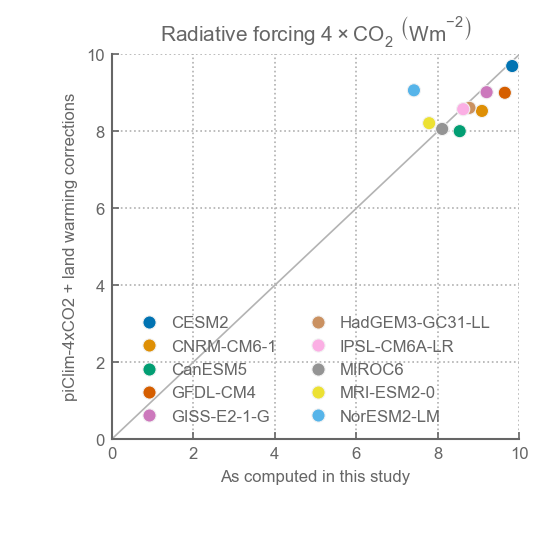

In [33]:
fig, ax = plt.subplots(figsize=(3.5,3.5))
y = ds.eei - ds.dRp_gf - ds.dRu  #.xtime.filter('lanczos', cutoff=10, order=1)
sns.scatterplot(df_F.dropna(), x='ERF_mean', y='sstClim_corrected', ax=ax, 
                hue='model', s=40, edgecolor='0.95', zorder=100, clip_on=False)
plt.axline((8,8), slope=1, ls='-', lw=.8, color='0.7')
ax.grid()
ax.set_ylim(0,10)
ax.set_xlim(0,10)
ax.legend(ncols=2, loc='lower center')
ax.set_title(r'Radiative forcing $4\times CO_2$ $\left(Wm^{-2}\right)$')
ax.set_ylabel(r'piClim-4xCO2 + land warming corrections')
ax.set_xlabel(r'As computed in this study')
plt.tight_layout()
plt.savefig('submission_plots/supplementary/compare_dF_sstClim_land_correction.pdf')
plt.savefig('submission_plots/supplementary/compare_dF_sstClim_land_correction.svg')
 

## Figure S3.1: EEI budget closure

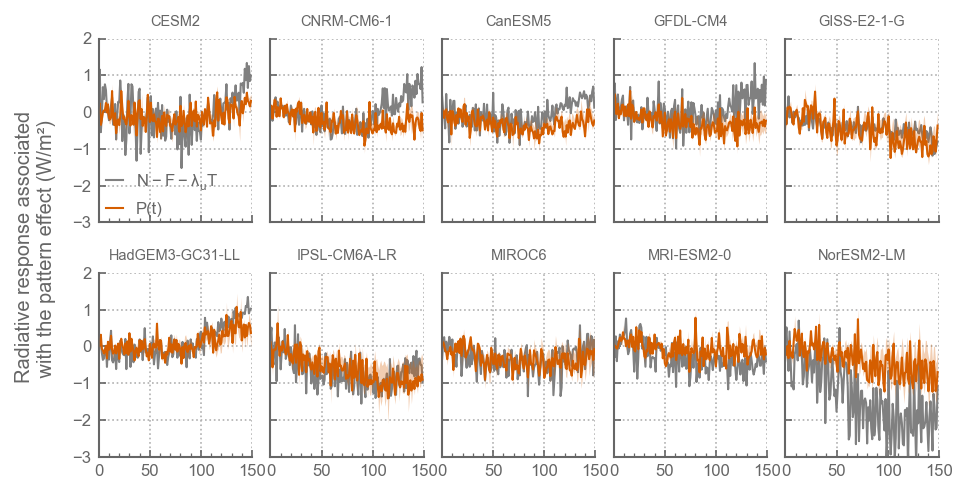

In [137]:
fig, axs = plt.subplots(2,5, figsize=(large_fig,5*2/3), sharex=True, sharey=True)
# eei_reco = 
all_delta = []
models = df_F.dropna().index
for k, ax in enumerate(axs.flatten()):
    eei = ds.sel(model=models[k]).eei
    f = df_F.loc[models[k]].sstClim_corrected
    dRp_reco = eei - np.log(1.01)/np.log(4)*f*ds.time - ds.sel(model=models[k]).dRu
    dRp_reco.plot(ax=ax, label=r'$N - F - \lambda_u T$', color='.5', lw=1)
    dRp_gf = ds.dRp_gf.sel(model=models[k])
    dRp_gf.sel(GF_source='mean').plot(ax=ax, color='C3', label='P(t)')
    quantiles_dRp = dRp_gf.quantile([0.17,0.83],'GF_source')
    # ax.fill_between(ds_model.time, dRp.min('GF_source'), dRp.max('GF_source'), color='C2', alpha=.3, lw=0)
    # 17 - 83
    ax.fill_between(quantiles_dRp.time, quantiles_dRp.sel(quantile=0.17), quantiles_dRp.sel(quantile=.83), color='C3', alpha=.3, lw=0, zorder=100)
    all_delta.append(dRp_reco -ds.dRp_gf.sel(model=models[k]) )
    ax.set_title(models[k], size=7)
    ax.set_xlabel('')
    ax.legend().remove()
    ax.grid()
    ax.set_ylabel('')
    ax.set_ylim(-3,2)
    ax.set_xlim(0,150)
    ax.xaxis.set_minor_locator(plt.MultipleLocator(10))
    ax.xaxis.set_major_locator(plt.MultipleLocator(50))

fig.supylabel('Radiative response associated\n with the pattern effect (W/m²)')
axs[0,0].legend(bbox_to_anchor=(-0.05,-0.05), loc ='lower left')
plt.tight_layout(w_pad=0)
plt.savefig('submission_plots/supplementary/comparing_pattern_effect_from_residuals_or_from_greens_functions.svg', dpi=300)
plt.savefig('submission_plots/supplementary/comparing_pattern_effect_from_residuals_or_from_greens_functions.pdf', dpi=300)

## Figure S3.2: EEI closure error versus temperature

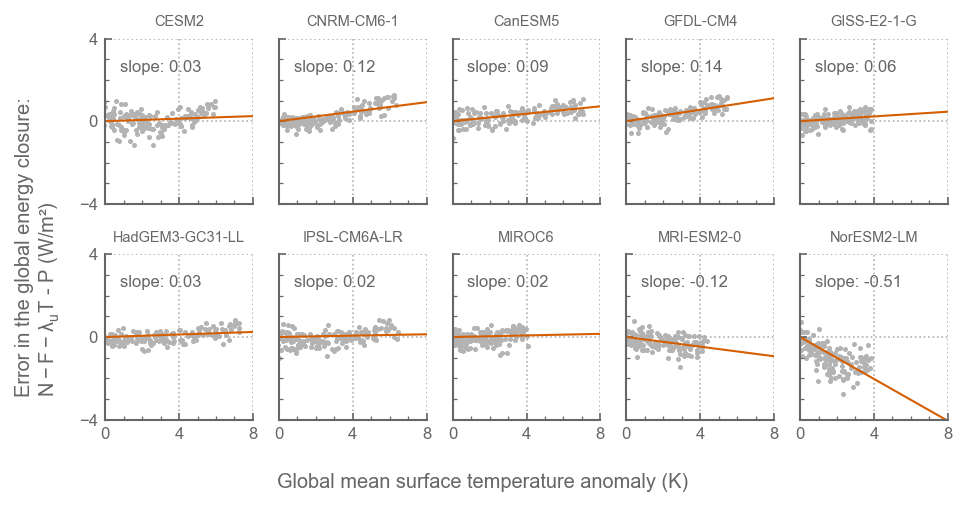

In [138]:
fig, axs = plt.subplots(2,5, figsize=(large_fig,5*2/3), sharex=True, sharey=True)
all_delta = []
models = df_F.dropna().index
for k, ax in enumerate(axs.flatten()):
    eei = ds.sel(model=models[k]).eei
    tas = ds.sel(model=models[k]).tas
    f = df_F.loc[models[k]].sstClim_corrected
    dRp_reco = eei - np.log(1.01)/np.log(4)*f*ds.time - ds.sel(model=models[k]).dRu
    dRp_gf = ds.dRp_gf.sel(model=models[k])#.lntime.plot(ax=ax, label = 'P(t)', add_legend=False, color='C3')
    x = tas 
    y = (-dRp_gf+dRp_reco).mean('GF_source')
    fit = curve_fit(lambda x,a : a*x, x, y)[0][0]
    ax.scatter(x,y, s=2, color='.7')
    ax.axline((0,0), slope=fit, color='C3', ls='-', lw=1)
    ax.text(0.1,0.8, f"slope: {fit:.02f}", transform=ax.transAxes)
    ax.set_title(models[k], size=7)
    ax.set_xlabel('')
    ax.grid()
    ax.set_ylabel('')
    ax.set_ylim(-4,4)
    ax.set_xlim(0,8)
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.xaxis.set_major_locator(plt.MultipleLocator(4))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(4))

fig.supylabel('Error in the global energy closure:\n'+r'$N - F - \lambda_u T$ - P (W/m²)')
fig.supxlabel('Global mean surface temperature anomaly (K)')
# axs[0,0].legend(bbox_to_anchor=(-0.05,-0.05), loc ='lower left')
plt.tight_layout(w_pad=1)
plt.savefig('submission_plots/supplementary/residuals_from_global_energy_budget_plotted_against_tas_for_mean_greens_function.svg', dpi=300)

## Figure S4: patterns of warming for all models

0it [00:00, ?it/s]

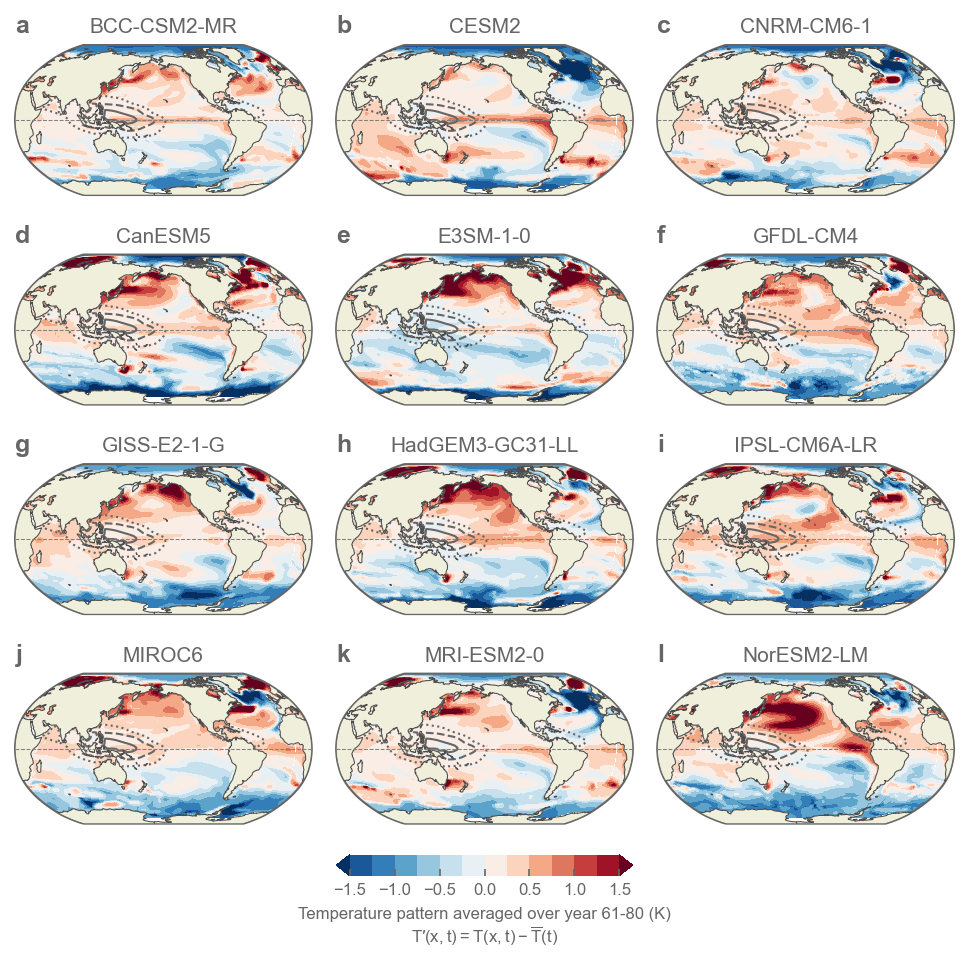

In [ ]:
fig, axs = plt.subplot_mosaic("""
                              ABC
                              DEF
                              GHI
                              JKL
                              .c.
                              """,
                              per_subplot_kw=dict(ABCDEFGHIJKL=dict(projection=ccrs.Robinson(200))),
                              height_ratios = [10,10,10,10,1], figsize=(large_fig,6.5))

for k,model in tqdm(enumerate(ds.model.values[:])):
    ax = list(axs.values())[k]
    plot = pattern_mean.sel(model=model).plot.contourf(cmap='RdBu_r', 
                                ax=ax,
                                transform=ccrs.PlateCarree(),
                                levels=np.arange(-1.5,1.7,.25), 
                                add_colorbar=False,)
    color_gf='.4'
    (1e3*mean_gf_normed).interpolate_na('lon').plot.contour(ax=ax,levels=np.arange(-3,4.1,1), colors=color_gf, linestyles=['-','--',':'], linewidths=[1,1,1,0], zorder=100, transform=ccrs.PlateCarree())
    ax.set_title(model)
    ax.set_title(chr(ord('a')+k), loc='left', weight='bold', size=12)
    ax.add_feature(cfeat.LAND, zorder=100, edgecolor='.3', linewidth=.5)
    ax.axhline(0, ls='--',zorder=101, color='.5', lw=.5)
cbar = fig.colorbar(plot, cax=axs['c'], orientation='horizontal',extend='both')
cbar.outline.set_visible(False)
cbar.minorlocator = mticker.MultipleLocator(10000)

axs['c'].set_xlabel('Temperature pattern averaged over year 61-80 (K)\n$T\prime(x,t) = T(x,t)-\overline{T}(t)$')
axs['c'].set_xticks(np.arange(-1.5,1.6,.5))
plt.tight_layout()
# plt.savefig('plots/pattern61-80.pdf')
# plt.savefig('plots/pattern61-80.svg')
plt.savefig('submission_plots/supplementary/pattern61-80.png', dpi=300)
plt.savefig('submission_plots/supplementary/pattern61-80.svg', dpi=300)

## Figure S5: pattern effect maps for all models

0it [00:00, ?it/s]

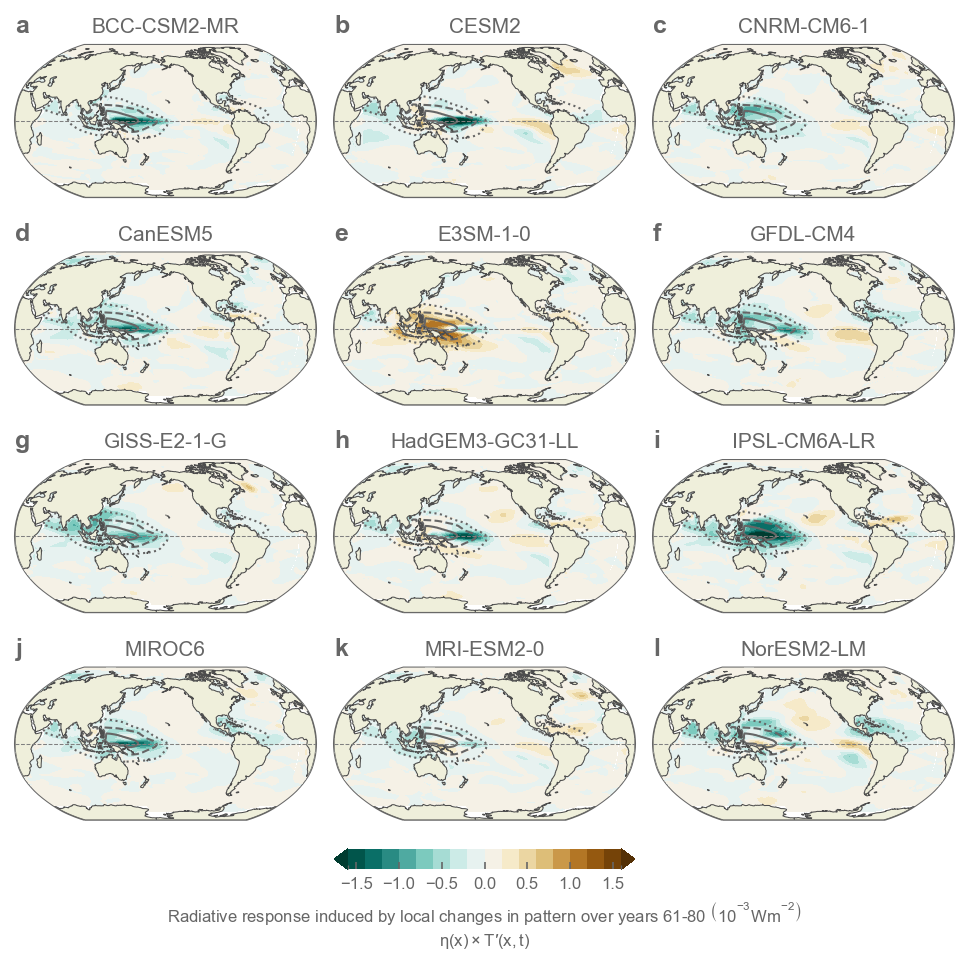

In [ ]:
fig, axs = plt.subplot_mosaic("""
                              ABC
                              DEF
                              GHI
                              JKL
                              .c.
                              """,
                              per_subplot_kw=dict(ABCDEFGHIJKL=dict(projection=ccrs.Robinson(200))),
                              height_ratios = [10,10,10,10,1], figsize=(large_fig,6.5))

for k,model in tqdm(enumerate(ds.model.values[:])):
    ax = list(axs.values())[k]
    plot = (mean_gf_normed*pattern_mean_regrid*1e3).interpolate_na('lon').sel(model=model).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), 
                                       cmap='BrBG_r',
                                       levels=np.arange(-1.6,1.7,.2),
                                       zorder=50,
                                       extend='both',
                                       add_colorbar=False)
    
    color_gf='.4'
    (1e3*mean_gf_normed).interpolate_na('lon').plot.contour(ax=ax,levels=np.arange(-3,4.1,1), colors=color_gf, linestyles=['-','--',':'], linewidths=[1,1,1,0], zorder=100, transform=ccrs.PlateCarree())
    ax.set_title(chr(ord('a')+k), loc='left', weight='bold', size=12)
    ax.add_feature(cfeat.LAND, zorder=100, edgecolor='.3', linewidth=.5)
    ax.axhline(0, ls='--',zorder=101, color='.5', lw=.5)
    ax.set_title(model)
cbar = fig.colorbar(plot, cax=axs['c'], orientation='horizontal',extend='both')
cbar.outline.set_visible(False)
cbar.minorlocator = mticker.MultipleLocator(10000)
axs['c'].set_xlabel(r'Radiative response induced by local changes in pattern over years 61-80 $\left(10^{-3}Wm^{-2}\right)$'+'\n'+r'$\eta(x)\times T\prime(x,t)$')
axs['c'].set_xticks(np.arange(-1.5,1.6,.5))
axs['c'].set_xticks(np.arange(-1.5,1.6,.5))

plt.tight_layout()
plt.savefig('submission_plots/supplementary/greens_functions_pattern61-80.png', dpi=300)
plt.savefig('submission_plots/supplementary/greens_functions_pattern61-80.svg', dpi=300)

In [119]:
np.sqrt(((ds.integrated_tas.sel(integration_type='full', depth='surface') - ds.tas).sel(GF_source='mean')**2).mean('time'))

<xarray.DataArray (model: 12)> Size: 96B
array([0.09403771, 0.1299659 , 0.17790095, 0.10535354, 0.14217385,
       0.10392979, 0.15696636, 0.10559892, 0.16017186, 0.1490058 ,
       0.09792732, 0.15368875])
Coordinates:
  * model             (model) <U15 720B 'BCC-CSM2-MR' 'CESM2' ... 'NorESM2-LM'
    GF_source         <U7 28B 'mean'
    height            float64 8B 2.0
    degree            int64 8B 1
    integration_type  <U12 48B 'full'
    depth             <U7 28B 'surface'
    Cs                (model) float64 96B ...
    Cd                (model) float64 96B ...
    gamma             (model) float64 96B ...

## Figure S8: Find non linearities CESM2

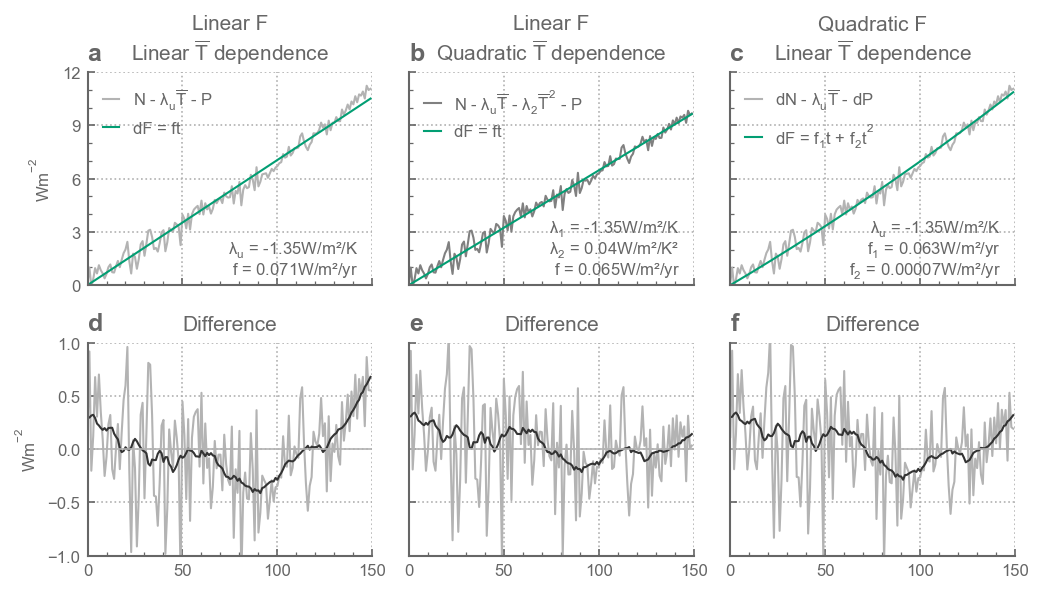

In [167]:
fig, axs = plt.subplots(2,3,figsize=(7,4), sharex=True, sharey='row')
ds_model = ds.sel(model='CESM2').sel(GF_source='mean')
dRu_lin = ds_model.lbd_u.values*ds_model.tas
# lbd_u
dRu_quad = ds_model.lbd_u.values*ds_model.tas + 0.04*ds_model.tas**2

y_lin = ds_model.eei - ds_model.dRp_gf - dRu_lin  #.lntime.filter('lanczos', cutoff=10, order=1)
y_quad = ds_model.eei - ds_model.dRp_gf - dRu_quad

y_lin.plot(ax=axs[0,0], color='.7', label='N - $\lambda_u \overline{T}$ - P')
f_lin = y_lin.curvefit('time', lambda x,f:f*x).curvefit_coefficients
lin_fit = f_lin.sel(param='f').values*ds_model.time
lin_fit.plot(ax=axs[0,0], label='dF = ft', color='C2')
(y_lin-lin_fit).plot(ax=axs[1,0], color='.7')
(y_lin-lin_fit).lntime.filter('moving_average', cutoff=20).plot(ax=axs[1,0], color='0.2')

y_quad.plot(ax=axs[0,1], color='.5', label='N - $\lambda_u\overline{T}$ - $\lambda_2 \overline{T}^2$ - P')
f_quadlbd = y_quad.curvefit('time', lambda x,f:f*x).curvefit_coefficients
quad_fit = f_quadlbd.sel(param='f').values*ds_model.time
quad_fit.plot(ax=axs[0,1], label='dF = ft', color='C2')
(y_quad-quad_fit).plot(ax=axs[1,1], color='.7')
(y_quad-quad_fit).lntime.filter('moving_average', cutoff=20).plot(ax=axs[1,1], color='0.2')


y_lin.plot(ax=axs[0,2], color='.7', label='dN - $\lambda_u \overline{T}$ - dP')
f_quad_dF = y_lin.curvefit('time', lambda x,f1,f2:f1*x+f2*x*x).curvefit_coefficients
quad_fit_dF = f_quad_dF.sel(param='f1').values*ds_model.time + f_quad_dF.sel(param='f2').values*(ds_model.time**2)
quad_fit_dF.plot(ax=axs[0,2], label='dF = $f_1$t + $f_2$t$^2$', color='C2')
(y_lin-quad_fit_dF).plot(ax=axs[1,2], color='.7')
(y_lin-quad_fit_dF).lntime.filter('moving_average', cutoff=20).plot(ax=axs[1,2], color='0.2')

axs[0,0].set_title('Linear F\nLinear '+r'$\overline{T}$ dependence')
axs[0,1].set_title('Linear F\nQuadratic ' +r'$\overline{T}$ dependence')
axs[0,2].set_title('Quadratic F\nLinear ' +r'$\overline{T}$ dependence')
axs[0,0].set_ylim(0,12)
axs[0,1].set_ylim(0,12)
axs[0,2].set_ylim(0,12)
axs[1,0].set_ylim(-1,1)
axs[1,1].set_ylim(-1,1)
axs[1,2].set_ylim(-1,1)
axs[1,0].axhline(0, ls='-', lw=.8, color='0.7')
axs[1,1].axhline(0, ls='-', lw=.8, color='0.7')
axs[1,2].axhline(0, ls='-', lw=.8, color='0.7')
axs[1,0].set_title('Difference')
axs[1,1].set_title('Difference')
axs[1,2].set_title('Difference')

for k,ax in enumerate(axs.flatten()):
    if k<3: 
        ax.legend()
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xlim(0,150)
    ax.grid()
axs[0,0].set_ylabel('$Wm^{-2}$')
axs[1,0].set_ylabel('$Wm^{-2}$')

axs[0,0].text(0.95,0.15,f"$\lambda_u$ = {ds_model.lbd_u.values:.02f}$W/m²/K$", transform=axs[0,0].transAxes, ha='right')
axs[0,0].text(0.95,0.05,f"$f$ = {f_lin.sel(param='f').values:.03f}$W/m²/yr$", transform=axs[0,0].transAxes, ha='right')

axs[0,1].text(0.95,0.25,f"$\lambda_1$ = {ds_model.lbd_u.values:.02f}$W/m²/K$", transform=axs[0,1].transAxes, ha='right')
axs[0,1].text(0.95,0.15,f"$\lambda_2$ = 0.04W/m²/K²", transform=axs[0,1].transAxes, ha='right')
axs[0,1].text(0.95,0.05,f"$f$ = {f_quadlbd.sel(param='f').values:.03f}$W/m²/yr$", transform=axs[0,1].transAxes, ha='right')

axs[0,2].text(0.95,0.25,f"$\lambda_u$ = {ds_model.lbd_u.values:.02f}$W/m²/K$", transform=axs[0,2].transAxes, ha='right')
axs[0,2].text(0.95,0.15,f"$f_1$ = {f_quad_dF.sel(param='f1').values:.03f}$W/m²/yr$", transform=axs[0,2].transAxes, ha='right')
axs[0,2].text(0.95,0.05,f"$f_2$ = {f_quad_dF.sel(param='f2').values:.05f}$W/m²/yr$", transform=axs[0,2].transAxes, ha='right')
for k, ax in enumerate(axs.flatten()):
    ax.set_title(chr(ord('a')+k), loc='left', size=12, weight='bold')

for k in range(3):
    axs[0,k].yaxis.set_major_locator(plt.MultipleLocator(3))
    axs[0,k].yaxis.set_minor_locator(plt.MultipleLocator(1))
    axs[0,k].xaxis.set_major_locator(plt.MultipleLocator(50))
    axs[0,k].xaxis.set_minor_locator(plt.MultipleLocator(10))
    axs[1,k].xaxis.set_major_locator(plt.MultipleLocator(50))
    axs[1,k].xaxis.set_minor_locator(plt.MultipleLocator(10))

# fig.suptitle('CESM2')
plt.tight_layout()
plt.savefig('submission_plots/supplementary/hypothesis_for_non_linear_behaviour.pdf')
plt.savefig('submission_plots/supplementary/hypothesis_for_non_linear_behaviour.svg')



## Figure S9: pattern effect in historical simulations

check quantiles !!

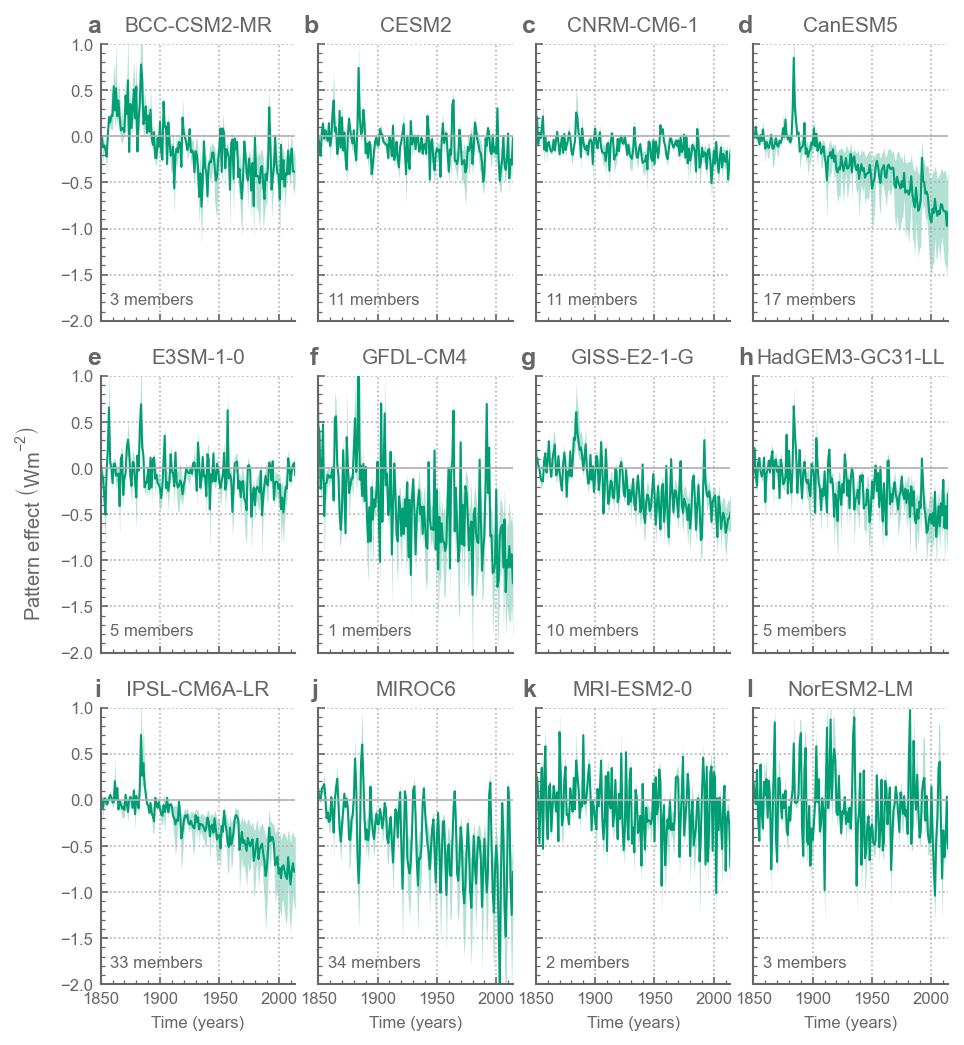

In [46]:
fig, axs = plt.subplots(3,4,figsize=(large_fig,7), sharex=True, sharey=True)
for k, ax in enumerate(axs.flatten()):
    dRp = dRp_hist.isel(model=k).assign_coords(time=range(1850,2015))
    # dRp = dRp.dRp
    dRp.mean('GF_source').plot(ax=ax, color='C2')
    # ax.fill_between(ds_model.time, dRp.min('GF_source'), dRp.max('GF_source'), color='C2', alpha=.3, lw=0)
    quantiles_dRp = dRp.quantile([0.17,0.83],'GF_source')
    # ax.fill_between(ds_model.time, dRp.min('GF_source'), dRp.max('GF_source'), color='C2', alpha=.3, lw=0)
    # 17 - 83
    ax.fill_between(quantiles_dRp.time, quantiles_dRp.sel(quantile=0.17), quantiles_dRp.sel(quantile=.83), color='C2', alpha=.3, lw=0)
    ax.set_title(dRp.model.values, size=10)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.xaxis.set_major_locator(mticker.MultipleLocator(50))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(10))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(.5))
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(.1))
    ax.axhline(0, **line_guide)
    ax.set_ylim(-2,1)
    ax.grid()
    ax.set_xlim(1850,2014)
    if k>7:
        ax.set_xlabel('Time (years)')
    ax.text(0,1.042,chr(ord('a')+k), transform=ax.transAxes, weight='bold', size=12, ha='right')
    members = ds_hist.dtos_global.isel(time=0).count('member_id').isel(model=k).values
    ax.text(0.05,0.05, f"{members} members",ha='left', va='bottom', size=8, transform=ax.transAxes)
fig.supylabel(r'Pattern effect $\left(Wm^{-2}\right)$')    
plt.tight_layout(w_pad=0)
plt.savefig("submission_plots/supplementary/Rp_hist.pdf")
plt.savefig("submission_plots/supplementary/Rp_hist.svg")

# Figures bonus

## Figure B1: SST $\sim$ TAS

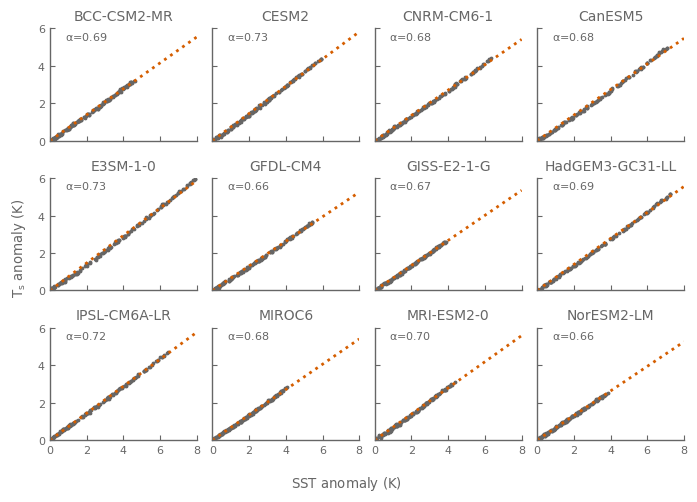

In [19]:
fig, axs = plt.subplots(3,4,figsize=(7,5), sharex=True, sharey=True)
for k, ax in enumerate(axs.flatten()):
    ds_model = ds.isel(model=k)
    ax.scatter(ds_model.tas, ds_model.dtos_1pctCO2, s=3, color='.4')
    ax.axline((0,0), slope=ds_model.alpha, color='C1', ls=':', lw=2)
    # ds_model.dR.plot(ax=ax, color='.5')
    # ds_model.dRp.plot(ax=ax, color='C1')
    # ds_model.dRu.plot(ax=ax, color='C2')
    # # ds_model.dRp_gf.mean('GF_source').plot(ax=ax, color='C1')
    ax.set_title(ds_model.model.values)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.text(0.1,0.9, r'$\alpha$'+f'={ds_model.alpha:.02f}', transform=ax.transAxes)
    # ax.xaxis.set_major_locator(mticker.MultipleLocator(50))
    # ax.xaxis.set_minor_locator(mticker.MultipleLocator(10))
    # ax.axhline(0, ls=':', lw=1, color='.5')
    ax.set_ylim(0,6)
    ax.set_xlim(0,8)
    # ax.set_xlim(0,150)
    # if k>5:
    #     ax.set_xlabel('Time (years)')

fig.supylabel('$T_s$ anomaly ($K$)')    
fig.supxlabel('$SST$ anomaly ($K$)')    
plt.tight_layout()


## Figure bonus 2: Reconstrtucting the EEI

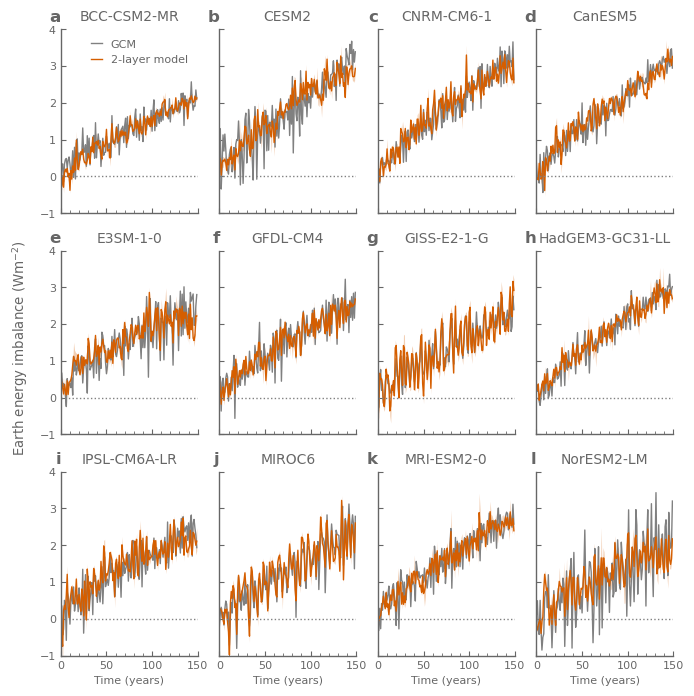

In [128]:
fig, axs = plt.subplots(3,4,figsize=(7,7), sharex=True, sharey=True)
for k, ax in enumerate(axs.flatten()):
    ds_model = ds.isel(model=k)
    ds_model
    eei_reco = ds_model.dR_reco + ds_model.dF
    # ds_model.dRp_gf.sel(GF_source='zhou').plot(ax=ax, color='0.8')
    # ds_model.dRp_gf.sel(GF_source='dong').plot(ax=ax, color='0.8')
    # ds_model.dRp_gf.sel(GF_source='zhang').plot(ax=ax, color='0.8')
    ds_model.eei.plot(ax=ax, color='.5', label='GCM')
    eei_reco.sel(GF_source='mean').plot(ax=ax, color='C1', label = '2-layer model')
    ax.fill_between(ds_model.time, eei_reco.min('GF_source'), eei_reco.max('GF_source'), color='C1', alpha=.3, lw=0)
    
    # ds_model.dRp_gf.mean('GF_source').plot(ax=ax, color='C1')
    ax.set_title(ds_model.model.values, size=10)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.xaxis.set_major_locator(mticker.MultipleLocator(50))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(10))
    ax.axhline(0, ls=':', lw=1, color='.5')
    ax.set_ylim(-1,4)
    ax.set_xlim(0,150)
    if k>7:
        ax.set_xlabel('Time (years)')
    ax.text(0,1.042,chr(ord('a')+k), transform=ax.transAxes, weight='bold', size=12, ha='right')
fig.supylabel('Earth energy imbalance ($Wm^{-2}$)')    
axs[0,0].legend()
plt.tight_layout(w_pad=0)
plt.savefig("plots/N_reco_Flin.pdf")

## Figure bonus 3: Compare three models

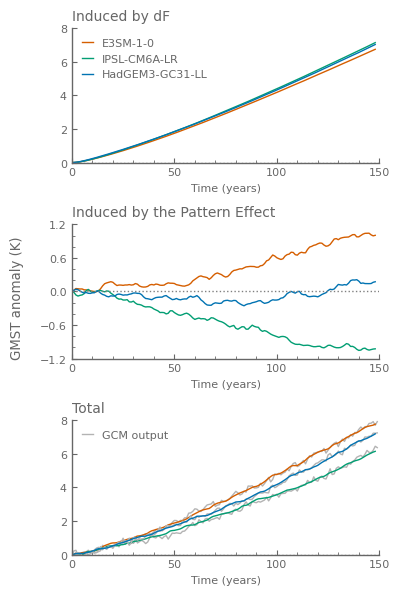

In [49]:

fig, axs = plt.subplots(3,1,figsize=(4,6))

colors =  ['C1', 'C2', "C0"]
models = ['E3SM-1-0','IPSL-CM6A-LR','HadGEM3-GC31-LL']
for k, model in enumerate(models):
    ds.integrated_tas.sel(integration_type='no_pattern', model=model, depth='surface', GF_source='mean').plot(ax=axs[0], label=model, color=colors[k])
    ds.integrated_tas.sel(integration_type='only_pattern', model=model, depth='surface', GF_source='mean').plot(ax=axs[1], color=colors[k])
    if k==0:
        label = 'GCM output'
    else:
        label=None
    ds.tas.sel(model=model).plot(ax=axs[2], color='.7', label=label)
    
    ds.integrated_tas.sel(integration_type='full', model=model, depth='surface', GF_source='mean').plot(ax=axs[2], color=colors[k])


for ax in axs:
    ax.set_title('')
    ax.axhline(0, lw=1, ls=':', color='.5')
    ax.set_xlim(0,150)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(50))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(10))
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xlabel('Time (years)')

fig.supylabel('GMST anomaly (K)')
axs[0].set_ylim(0,8)
axs[2].set_ylim(0,8)
axs[1].set_ylim(-1.2,1.2)


axs[1].yaxis.set_major_locator(mticker.MultipleLocator(.6))
axs[1].yaxis.set_minor_locator(mticker.MultipleLocator(.2))
axs[0].set_title('Induced by dF', loc='left')
axs[1].set_title('Induced by the Pattern Effect', loc='left')
axs[2].set_title('Total', loc='left')
axs[0].legend()
axs[2].legend()


# ds.integrated_tas.sel(integration_type='full', model='E3SM-1-0', depth='surface', GF_source='zhou').plot()
# ds.integrated_tas.sel(integration_type='full', model='HadGEM3-GC31-LL', depth='surface', GF_source='zhou').plot()

plt.tight_layout()
plt.savefig('plots/compare_3models.pdf')
plt.savefig('plots/compare_3models.svg')



## Figure bonus 4: Compare historical pattern trend with 1pctCO2

0.5714958258102616


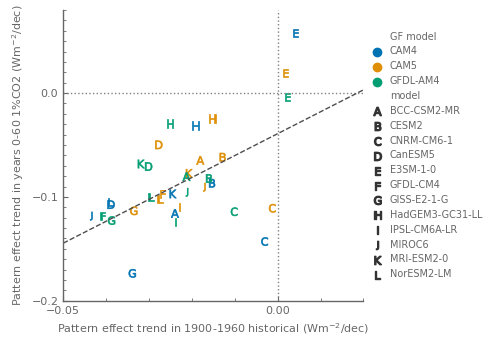

In [97]:
# dRp_hist = ds_hist.dRp.where(ds_hist.dtos_global.notnull())
fig, ax = plt.subplots(figsize=(5,3.5))
trends_hist = ds_hist_m.assign_coords(time=range(1850,2015)).sel(time=slice(1900,1960)).dRp.polyfit('time', deg=1).polyfit_coefficients.sel(degree=1,drop=True)*10
trends_1pct = ds.dRp_gf.sel(time=slice(0,60)).polyfit('time', deg=1).polyfit_coefficients.sel(degree=1,drop=True)*10

df = pd.DataFrame(dict(thist = trends_hist.to_series(), t1pct=trends_1pct.to_series())).reset_index().dropna()
df.columns = ["GF model","model","thist","t1pct"]
df["GF model"] = ["CAM4" for k in range(12)]+["CAM5" for k in range(12)] + ["GFDL-AM4" for k in range(12)]

markers = [f"${chr(ord('A')+k)}$" for k in range(12)]
sns.scatterplot(df, x='thist', y='t1pct',  style='model', ax=ax, markers=markers, edgecolor=None, hue='GF model')
ax.legend(loc='center left', fontsize=7,bbox_to_anchor=(1,.5), )
# axs['C'].legend(bbox_to_anchor=(0.5,-.5), loc='lower center', ncol=2, fontsize=6).remove()
# plot_timeseries_uncertainty(ds_hist.dRp.mean('GF_source').sel(time=slice('1975','2014')).mean('member_id').assign_coords(time=range(40)),  label='historical', ax=axs["C"], thick_line_color='C2', thick_line='median', shaded_area='std')

ax.set_xlim(-0.05,0.02)
ax.set_ylim(-0.2,0.08)
ax.xaxis.set_major_locator(mticker.MultipleLocator(0.05))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.01))
ax.yaxis.set_major_locator(mticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.01))

ax.axhline(0, ls=':', lw=1, color='.5')
ax.axvline(0, ls=':', lw=1, color='.5')
ax.set_ylabel('Pattern effect trend in years 0-60 1%CO2 ($Wm^{-2}$/dec)')
ax.set_xlabel('Pattern effect trend in 1900-1960 historical ($Wm^{-2}$/dec)')
lr = linregress(df.thist, df.t1pct)
ax.axline((0,lr.intercept), slope=lr.slope, color='0.3', ls='--')
print(lr.rvalue)
plt.tight_layout()
plt.savefig('plots/compare_1pct_trend_with_hist_trend.pdf')
plt.savefig('plots/compare_1pct_trend_with_hist_trend.svg')